<a href="https://colab.research.google.com/github/Bilel-Marzougui/posturologie/blob/main/Pose%20estiamtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Setup

In [ ]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install google.colab --quiet

In [ ]:
# Imports
import re
import os
import cv2
import json
import torch
import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm
from glob import glob

In [ ]:
# @title Helper function
def PlotLabelAndPrediction(batch, hm_pred, idx=None, title_string=''):
  """
  PlotLabelAndPrediction(batch,pred,idx=None):
  Plot the input, labels, and predictions for a batch.
  """
  isbatch = isinstance(batch['id'], torch.Tensor)

  if idx is None and isbatch:
    idx = range(len(batch['id']))
  if isbatch:
    n = len(idx)
  else:
    n = 1
    idx = [None,]
  locs_pred = heatmap2landmarks(hm_pred.cpu().numpy())
  for i in range(n):

    plt.subplot(n, 4, 4*i + 1)
    im = COCODataset.get_image(batch, idx[i])
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if isbatch:
      batchid = batch['id'][i]
    else:
      batchid = batch['id']
    plt.title(f"{title_string}{batchid}")

    plt.subplot(n, 4, 4*i + 2)
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    if isbatch:
      locs_pred_curr = locs_pred[i, ...]
    else:
      locs_pred_curr = locs_pred
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs_pred_curr[k, 0], locs_pred_curr[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if i == 0: plt.title('pred')

    plt.subplot(n, 4, 4*i + 3)
    hmim = COCODataset.get_heatmap_image(batch, idx[i])
    plt.imshow(hmim)
    if i == 0: plt.title('label')

    plt.subplot(n, 4, 4*i + 4)
    if isbatch:
      predcurr = hm_pred[idx[i], ...]
    else:
      predcurr = hm_pred
    plt.imshow(heatmap2image(predcurr.cpu().numpy(), colors=colors))
    if i == 0: plt.title('pred')  

In [ ]:
print(f"numpy version: {np.__version__}")
print(f"\nCUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\ntorch version: {torch.__version__}")

numpy version: 1.21.6

CUDA available: True

torch version: 1.11.0+cu113


In [ ]:
# @title Download the data
import os, requests, tarfile

datadir = '/content/posebb'

In [ ]:
gDrive = False

In [ ]:
# @markdown set the `gDrive=True` and run the cell.
from google.colab import drive

if gDrive:
  print('The first time you run this, it will ask you to verify that Google Colab can access your Google Drive.')
  print('Follow the instructions -- go to the linked website, and copy-paste the provided code.')
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)
  assert os.path.exists('/content/drive/My Drive'), 'Google drive not mounted'

  # Unzip fly pose data
  datadir = 'view0'
  if not os.path.exists(datadir):
    assert os.path.exists('/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz'), 'Fly pose data zip file not found'
    !tar -xvzf '/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz' > /dev/null
    assert os.path.exists(datadir), 'view0 not created after unzipping data'
  else:
    print('Fly pose data already unzipped')

In [ ]:
# Make sure all the data exists
traindir = os.path.join(datadir, 'train')
trainannfile = os.path.join(datadir, 'train_annotations.json')
testdir = os.path.join(datadir, 'test')
testannfile = os.path.join(datadir, 'test_annotations.json')
assert os.path.exists(traindir) and os.path.exists(testdir) and os.path.exists(trainannfile) and os.path.exists(testannfile), 'Could not find all necessary data after unzipping'
print('Found all data')

# Read annotation information
with open(trainannfile) as f:
  trainann = json.load(f)
f.close()
ntrainims = len(trainann['images'])
# Make sure we have all the images
t = glob(os.path.join(traindir,'*.jpg'))
print(f"N. train images = {ntrainims}, number of images unzipped = {len(t)}")
assert ntrainims == len(t), 'number of annotations and number of images do not match'

# get some features of the data set
i = 0
filestr = trainann['images'][0]['file_name']
imfile = os.path.join(traindir,filestr)
im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
imsize = im.shape
if len(imsize) == 2:
  imsize += (1, )
print(f"input image size: {imsize}")

landmark_names = ["nasion ", "t.droit", "t.gauche", "p.menton", "frouchette", "arti.droite", "arti.gauche", "appendice", "ombilic", "aile.droite", "aile.gauche", "pubis"]
skeleton=[[1,4],[2,3],[4,5],[5,8],[6,7],[8,9],[9,12],[10,11]]
nlandmarks = trainann['annotations'][0]['num_keypoints']
assert nlandmarks == len(landmark_names)

Found all data
N. train images = 30, number of images unzipped = 30
input image size: (875, 606, 3)


---
# Visulaize the data

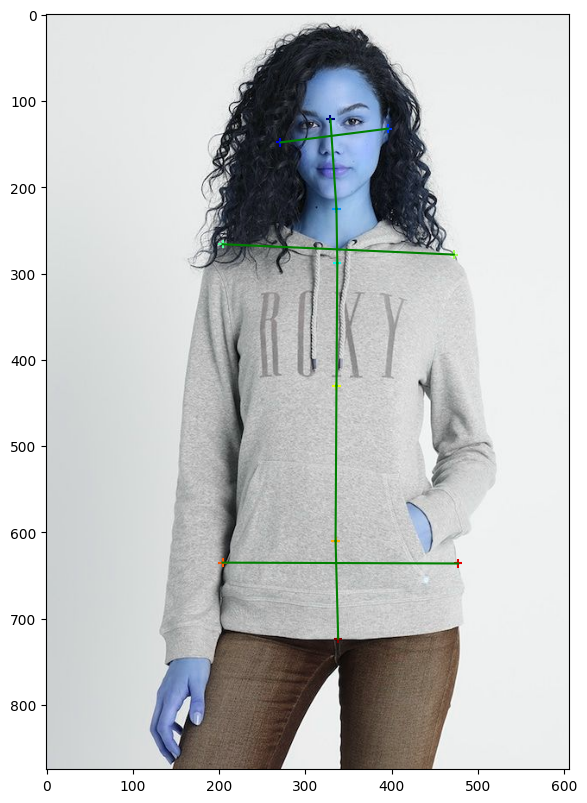

In [ ]:
             
# Show some example images

fig = plt.figure(figsize=(10, 10), dpi=100)  # make the figure bigger
i=29
filestr = trainann['images'][i]['file_name']
imfile = os.path.join(traindir, filestr)
im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
plt.imshow(im,cmap='gray')
x = trainann['annotations'][i]['keypoints'][::3]
y = trainann['annotations'][i]['keypoints'][1::3]
plt.scatter(x, y, marker='+', c=np.arange(nlandmarks), cmap='jet')
skeleton=[[1,4],[2,3],[4,5],[5,8],[6,7],[8,9],[9,12],[10,11]]
bone_list = np.array(skeleton) - 1
for bone in bone_list:
    plt.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'g')
plt.show()


In [ ]:
# define a dataset class to load the data

def heatmap2image(hm, cmap='jet', colors=None):
  """
  heatmap2image(hm,cmap='jet',colors=None)
  Creates and returns an image visualization from landmark heatmaps. Each
  landmark is colored according to the input cmap/colors.
  Inputs:
    hm: nlandmarks x height x width ndarray, dtype=float in the range 0 to 1.
    hm[p,i,j] is a score indicating how likely it is that the pth landmark
    is at pixel location (i,j).
    cmap: string.
    Name of colormap for defining colors of landmark points. Used only if colors
    is None.
    Default: 'jet'
    colors: list of length nlandmarks.
    colors[p] is an ndarray of size (4,) indicating the color to use for the
    pth landmark. colors is the output of matplotlib's colormap functions.
    Default: None
  Output:
    im: height x width x 3 ndarray
    Image representation of the input heatmap landmarks.
  """
  hm = np.maximum(0., np.minimum(1. ,hm))
  im = np.zeros((hm.shape[1], hm.shape[2], 3))
  if colors is None:
    if isinstance(cmap, str):
      cmap = matplotlib.cm.get_cmap(cmap)
    colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
    colors = cmap(colornorm(np.arange(hm.shape[0])))
  for i in range(hm.shape[0]):
    color = colors[i]
    for c in range(3):
      im[..., c] = im[..., c] + (color[c] * .7 + .3) * hm[i, ...]
  im = np.minimum(1.,im)

  return im


class COCODataset(torch.utils.data.Dataset):
  """
  COCODataset
  Torch Dataset based on the COCO keypoint file format.
  """

  def __init__(self, annfile, datadir=None, label_sigma=3.,
               transform=None, landmarks=None):
    """
    Constructor
    This must be defined in every Torch Dataset and can take any inputs you
    want it to.
    Inputs:
      annfile: string
      Path to json file containing annotations.
      datadir: string
      Path to directory containing images. If None, images are assumed to be in
      the working directory.
      Default: None
      label_sigma: scalar float
      Standard deviation in pixels of Gaussian to be used to make the landmark
      heatmap.
      Default: 3.
      transform: None
      Not used currently
      landmarks: ndarray (or list, something used for indexing into ndarray)
      Indices of landmarks available to use in this dataset. Reducing the
      landmarks used can make training faster and require less memory, and is
      useful for testing code. If None, all landmarks are used.
      Default: None
    """

    # read in the annotations from the json file
    with open(annfile) as f:
      self.ann = json.load(f)
    # where the images are
    self.datadir = datadir

    # landmarks to use
    self.nlandmarks_all = self.ann['annotations'][0]['num_keypoints']
    if landmarks is None:
      self.nlandmarks = self.nlandmarks_all
    else:
      self.nlandmarks = len(landmarks)
    self.landmarks = landmarks

    # for data augmentation/rescaling
    self.transform = transform

    # output will be heatmap images, one per landmark, with Gaussian values
    # around the landmark location -- precompute some stuff for that
    self.label_filter = None
    self.label_filter_r = 1
    self.label_filter_d = 3
    self.label_sigma = label_sigma
    self.init_label_filter()

  def __len__(self):
    """
    Overloaded len function.
    This must be defined in every Torch Dataset and must take only self
    as input.
    Returns the number of examples in the dataset.
    """
    return len(self.ann['images'])

  def __getitem__(self, item):
    """
    Overloaded getitem function.
    This must be defined in every Torch Dataset and must take only self
    and item as input. It returns example number item.
    item: scalar integer.
    The output example is a dict with the following fields:
    image: torch float32 tensor of size ncolors x height x width
    landmarks: nlandmarks x 2 float ndarray
    heatmaps: torch float32 tensor of size nlandmarks x height x width
    id: scalar integer, contains item
    """

    # read in the image for training example item
    # and convert to a torch tensor
    filename = self.ann['images'][item]['file_name']
    if self.datadir is not None:
      filename = os.path.join(self.datadir, filename)
    assert os.path.exists(filename)
    im = torch.from_numpy(cv2.imread(filename, cv2.IMREAD_UNCHANGED))

    # convert to float32 in the range 0. to 1.
    if im.dtype == float:
      pass
    elif im.dtype == torch.uint8:
      im = im.float() / 255.
    elif im.dtype == torch.uint16:
      im = im.float() / 65535.
    else:
      print('Cannot handle im type '+str(im.dtype))
      raise TypeError

    imsz = im.shape
    # convert to a tensor of size ncolors x h x w
    if im.dim() == 3:
      im = torch.permute(im, (2, 0, 1))  # now 3 x h x w
    else:
      im = torch.unsqueeze(im, 0)  # now 1 x h x w

    # landmark locations
    locs = np.reshape(self.ann['annotations'][item]['keypoints'],
                      [self.nlandmarks_all, 3])
    locs = locs[:, :2]
    if self.landmarks is not None:
      locs = locs[self.landmarks, :]

    # create heatmap target prediction
    heatmaps = self.make_heatmap_target(locs, imsz)

    # return a dict with the following fields:
    # image: torch float32 tensor of size ncolors x height x width
    # landmarks: nlandmarks x 2 float ndarray
    # heatmaps: torch float32 tensor of size nlandmarks x height x width
    # id: scalar integer, contains item
    features = {'image':im,
                'landmarks':locs.astype(np.float32),
                'heatmaps':heatmaps,
                'id':item}

    return features

  def init_label_filter(self):
    """
    init_label_filter(self)
    Helper function
    Create a Gaussian filter for the heatmap target output
    """
    # radius of the filter
    self.label_filter_r = max(int(round(3 * self.label_sigma)), 1)
    # diameter of the filter
    self.label_filter_d = 2 * self.label_filter_r + 1

    # allocate
    self.label_filter = np.zeros([self.label_filter_d, self.label_filter_d])
    # set the middle pixel to 1.
    self.label_filter[self.label_filter_r, self.label_filter_r] = 1.
    # blur with a Gaussian
    self.label_filter = cv2.GaussianBlur(self.label_filter,
                                         (self.label_filter_d,
                                          self.label_filter_d),
                                         self.label_sigma)
    # normalize
    self.label_filter = self.label_filter / np.max(self.label_filter)
    # convert to torch tensor
    self.label_filter = torch.from_numpy(self.label_filter)

  def make_heatmap_target(self, locs, imsz):
    """
    make_heatmap_target(self,locs,imsz):
    Helper function
    Creates the heatmap tensor of size imsz corresponding to landmark locations locs
    Inputs:
      locs: nlandmarks x 2 ndarray
      Locations of landmarks
      imsz: image shape
    Returns:
      target: torch tensor of size nlandmarks x imsz[0] x imsz[1]
      Heatmaps corresponding to locs
    """
    # allocate the tensor
    target = torch.zeros((locs.shape[0], imsz[0], imsz[1]), dtype=torch.float32)
    # loop through landmarks
    for i in range(locs.shape[0]):
      # location of this landmark to the nearest pixel
      x = int(np.round(locs[i, 0])) # losing sub-pixel accuracy
      y = int(np.round(locs[i, 1]))
      # edges of the Gaussian filter to place, minding border of image
      x0 = np.maximum(0, x - self.label_filter_r)
      x1 = np.minimum(imsz[1] - 1, x + self.label_filter_r)
      y0 = np.maximum(0, y - self.label_filter_r)
      y1 = np.minimum(imsz[0] - 1, y + self.label_filter_r)
      # crop filter if it goes outside of the image
      fil_x0 = self.label_filter_r - (x - x0)
      fil_x1 = self.label_filter_d - (self.label_filter_r - (x1 - x))
      fil_y0 = self.label_filter_r - (y - y0)
      fil_y1 = self.label_filter_d - (self.label_filter_r - (y1 - y))
      # copy the filter to the relevant part of the heatmap image
      target[i, y0:y1 + 1, x0:x1 + 1] = self.label_filter[fil_y0:fil_y1 + 1,
                                                          fil_x0:fil_x1 + 1]

    return target

  @staticmethod
  def get_image(d, i=None):
    """
    static function, used for visualization
    COCODataset.get_image(d,i=None)
    Returns an image usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    Returns the ith image from the patch as an ndarray plottable with
    plt.imshow()
    """
    if i is None:
      im = np.squeeze(np.transpose(d['image'], (1, 2, 0)), axis=2)
    else:
      im = np.squeeze(np.transpose(d['image'][i,...], (1, 2, 0)), axis=2)
    return im

  @staticmethod
  def get_landmarks(d, i=None):
    """
    static helper function
    COCODataset.get_landmarks(d,i=None)
    Returns a nlandmarks x 2 ndarray indicating landmark locations.
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    """
    if i is None:
      locs = d['landmarks']
    else:
      locs = d['landmarks'][i]
    return locs

  @staticmethod
  def get_heatmap_image(d, i, cmap='jet', colors=None):
    """
    static function, used for visualization
    COCODataset.get_heatmap_image(d,i=None)
    Returns an image visualization of heatmaps usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
      Returns the ith heatmap from the patch as an ndarray plottable with
      plt.imshow()
      cmap: string.
      Name of colormap for defining colors of landmark points. Used only if colors
      is None.
      Default: 'jet'
      colors: list of length nlandmarks.
      colors[p] is an ndarray of size (4,) indicating the color to use for the
      pth landmark. colors is the output of matplotlib's colormap functions.
      Default: None
    Output:
      im: height x width x 3 ndarray
      Image representation of the input heatmap landmarks.
    """
    if i is None:
      hm = d['heatmaps']
    else:
      hm = d['heatmaps'][i, ...]
    hm = hm.numpy()
    im = heatmap2image(hm, cmap=cmap, colors=colors)

    return im

{'image': tensor([[[[0.8588, 0.8588, 0.8588,  ..., 0.8667, 0.8667, 0.8667],
          [0.8588, 0.8588, 0.8588,  ..., 0.8667, 0.8667, 0.8667],
          [0.8588, 0.8588, 0.8588,  ..., 0.8667, 0.8667, 0.8667],
          ...,
          [0.7216, 0.7216, 0.7216,  ..., 0.8471, 0.8471, 0.8471],
          [0.7216, 0.7216, 0.7216,  ..., 0.8471, 0.8471, 0.8471],
          [0.7216, 0.7216, 0.7216,  ..., 0.8471, 0.8471, 0.8471]],

         [[0.8627, 0.8627, 0.8627,  ..., 0.8706, 0.8706, 0.8706],
          [0.8627, 0.8627, 0.8627,  ..., 0.8706, 0.8706, 0.8706],
          [0.8627, 0.8627, 0.8627,  ..., 0.8706, 0.8706, 0.8706],
          ...,
          [0.7451, 0.7451, 0.7451,  ..., 0.8588, 0.8588, 0.8588],
          [0.7451, 0.7451, 0.7451,  ..., 0.8588, 0.8588, 0.8588],
          [0.7451, 0.7451, 0.7451,  ..., 0.8588, 0.8588, 0.8588]],

         [[0.8549, 0.8549, 0.8549,  ..., 0.8627, 0.8627, 0.8627],
          [0.8549, 0.8549, 0.8549,  ..., 0.8627, 0.8627, 0.8627],
          [0.8549, 0.8549, 0.854

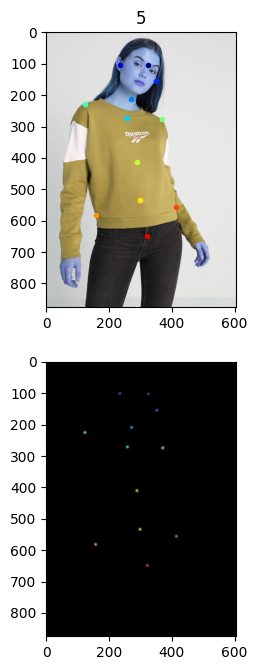

In [ ]:
# instantiate train data loader

# only use a subset of the landmarks
#landmarks = np.where(list(map(lambda x: x in ['head_fc','leg_fl_tip','leg_fr_tip'],landmark_names)))[0]
# use all the landmarks

landmarks = None

train_dataset = COCODataset(trainannfile, datadir=traindir, landmarks=landmarks)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=2,
                                               shuffle=True)

# plot example images using the dataloader
fig = plt.figure(figsize=(1* 4, 8), dpi=100)

# choose some colors for each landmark
cmap = matplotlib.cm.get_cmap('jet')
colornorm = matplotlib.colors.Normalize(vmin=0, vmax=train_dataset.nlandmarks)
colors = cmap(colornorm(np.arange(train_dataset.nlandmarks)))

count = 0
for i_batch, sample_batch in enumerate(train_dataloader):
  for j in range(len(sample_batch['id'])):
    plt.subplot(2, 1, count + 1)
    # use our helper functions for getting and formatting data from the batch
    im = COCODataset.get_image(sample_batch, j)
    locs = COCODataset.get_landmarks(sample_batch, j)
    plt.imshow(im, cmap='gray')
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1], marker='.', color=colors[k],
               markerfacecolor=colors[k])
    plt.title('%d'%sample_batch['id'][j])
    hmim = COCODataset.get_heatmap_image(sample_batch, j, colors=colors)
    plt.subplot(2, 1, count + 2)
    plt.imshow(hmim)
    count += 1
    if count >= 1:
      break
  if count >= 1:
    break

# Show the structure of a batch
print(sample_batch)

---
# Architectures

In [ ]:
# Define network structure - UNet
# Copy-paste & modify from https://github.com/milesial/Pytorch-UNet

# The UNet is defined modularly.
# It is a series of downsampling layers defined by the module Down
# followed by upsampling layers defined by the module Up. The output is
# a convolutional layer with an output channel for each landmark, defined by
# the module OutConv.
# Each down and up layer is actually two convolutional layers with
# a ReLU nonlinearity and batch normalization, defined by the module
# DoubleConv.
# The Down module consists of a 2x2 max pool layer followed by the DoubleConv
# module.
# The Up module consists of an upsampling, either defined via bilinear
# interpolation (bilinear=True), or a learned convolutional transpose, followed
# by a DoubleConv module.
# The Output layer is a single 2-D convolutional layer with no nonlinearity.
# The nonlinearity is incorporated into the network loss function.

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
        )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)


  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

# copy-pasted and modified from unet_model.py

class UNet(nn.Module):
  def __init__(self, n_channels, n_landmarks, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_landmarks = n_landmarks
    self.bilinear = bilinear
    self.nchannels_inc = 8

    # define the layers

    # number of channels in the first layer
    nchannels_inc = self.nchannels_inc
    # increase the number of channels by a factor of 2 each layer
    nchannels_down1 = nchannels_inc*2
    nchannels_down2 = nchannels_down1*2
    nchannels_down3 = nchannels_down2*2
    # decrease the number of channels by a factor of 2 each layer
    nchannels_up1 = nchannels_down3//2
    nchannels_up2 = nchannels_up1//2
    nchannels_up3 = nchannels_up2//2

    if bilinear:
      factor = 2
    else:
      factor = 1

    self.layer_inc = DoubleConv(n_channels, nchannels_inc)

    self.layer_down1 = Down(nchannels_inc, nchannels_down1)
    self.layer_down2 = Down(nchannels_down1, nchannels_down2)
    self.layer_down3 = Down(nchannels_down2, nchannels_down3//factor)

    self.layer_up1 = Up(nchannels_down3, nchannels_up1//factor, bilinear)
    self.layer_up2 = Up(nchannels_up1, nchannels_up2//factor, bilinear)
    self.layer_up3 = Up(nchannels_up2, nchannels_up3//factor, bilinear)

    self.layer_outc = OutConv(nchannels_up3//factor, self.n_landmarks)

  def forward(self, x, verbose=False):
    x1 = self.layer_inc(x)
    if verbose: print(f'inc: shape = {x1.shape}')
    x2 = self.layer_down1(x1)
    if verbose:print(f'inc: shape = {x2.shape}')
    x3 = self.layer_down2(x2)
    if verbose: print(f'inc: shape = {x3.shape}')
    x4 = self.layer_down3(x3)
    if verbose: print(f'inc: shape = {x4.shape}')
    x = self.layer_up1(x4, x3)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up2(x, x2)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up3(x, x1)
    if verbose: print(f'inc: shape = {x.shape}')
    logits = self.layer_outc(x)
    if verbose: print(f'outc: shape = {logits.shape}')

    return logits

  def output(self, x, verbose=False):
    return torch.sigmoid(self.forward(x, verbose=verbose))

  def __str__(self):
    s = ''
    s += 'inc: '+str(self.layer_inc)+'\n'
    s += 'down1: '+str(self.layer_down1)+'\n'
    s += 'down2: '+str(self.layer_down2)+'\n'
    s += 'down3: '+str(self.layer_down3)+'\n'
    s += 'up1: '+str(self.layer_up1)+'\n'
    s += 'up2: '+str(self.layer_up2)+'\n'
    s += 'up3: '+str(self.layer_up3)+'\n'
    s += 'outc: '+str(self.layer_outc)+'\n'
    return s

  def __repr__(self):
    return str(self)


def heatmap2landmarks(hms):
  idx = np.argmax(hms.reshape(hms.shape[:-2] + (hms.shape[-2]*hms.shape[-1], )),
                  axis=-1)
  locs = np.zeros(hms.shape[:-2] + (2, ))
  locs[...,1],locs[...,0] = np.unravel_index(idx,hms.shape[-2:])
  return locs

In [ ]:
# Insantiate the network
net = UNet(n_channels=imsize[-1], n_landmarks=train_dataset.nlandmarks)
net.to(device=device) # have to be careful about what is done on the CPU vs GPU
# try the network out before training
batch = next(iter(train_dataloader))
with torch.no_grad():
  hms0 = net.output(batch['image'].to(device=device), verbose=True)

fig = plt.figure(figsize=(12, 4*len(batch['id'])), dpi= 100)
PlotLabelAndPrediction(batch, hms0)

AttributeError: ignored

In [ ]:
# load a network if one is already saved and you want to restart training
# savefile = '/content/drive/My Drive/PoseEstimationNets/UNet20210510T140305/Final_epoch4.pth'
savefile = None
loadepoch = 0
# savefile = None
if savefile is not None:
  net.load_state_dict(
      torch.load(savefile, map_location=device)
      )
  m = re.search('[^\d](?P<epoch>\d+)\.pth$', savefile)
  if m is None:
    print('Could not parse epoch from file name')
  else:
    loadepoch = int(m['epoch'])
    print(f"Parsed epoch from loaded net file name: {loadepoch}")
  net.to(device=device)

In [ ]:
# train the network
# following https://github.com/milesial/Pytorch-UNet/blob/master/train.py

# parameters related to training the network
batchsize = 10# number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
nepochs =1000  # number of times to cycle through all the data during training
learning_rate = 0.00025 # initial learning rate
weight_decay = 1e-8 # how learning rate decays over time
momentum = 0.99 # how much to use previous gradient direction
nepochs_per_save = 1 # how often to save the network
val_frac = 0.1 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
from datetime import datetime
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')
# If you use your gDrive do not forget to set `gDrive` to `True`
if gDrive:
  savedir = '/content/drive/My Drive/PoseEstimationNets'
else:
  savedir = '/content/PoseEstimationNets'

# if the folder does not exist, create it.
if not os.path.exists(savedir):
  os.mkdir(savedir)

checkpointdir = os.path.join(savedir, 'UNet' + timestamp)
os.mkdir(checkpointdir)

# split into train and validation datasets
n_val = int(len(train_dataset) * val_frac)
n_train = len(train_dataset) - n_val
train, val = torch.utils.data.random_split(train_dataset, [n_train, n_val])
train_dataloader = torch.utils.data.DataLoader(train,
                                               batch_size=batchsize,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val,
                                             batch_size=batchsize,
                                             shuffle=False)

# gradient descent flavor
optimizer = optim.RMSprop(net.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay,
                          momentum=momentum
                       )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

# Following https://github.com/milesial/Pytorch-UNet
# Use binary cross entropy loss combined with sigmoid output activation function.
# We combine here for numerical improvements
criterion = nn.BCEWithLogitsLoss()

# store loss per epoch
epoch_losses = np.zeros(nepochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# how many gradient descent updates we have made
iters = loadepoch*len(train_dataloader)

# loop through entire training data set nepochs times
for epoch in range(loadepoch, nepochs):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  with tqdm(total=ntrainims,
            desc=f"Epoch {epoch + 1}/{nepochs}",
            unit='img') as pbar:

    # loop through each batch in the training data
    for batch in train_dataloader:
      # compute the loss
      imgs = batch['image']
      imgs = imgs.to(device=device, dtype=torch.float32) # transfer to GPU
      hm_labels = batch['heatmaps']
      hm_labels = hm_labels.to(device=device, dtype=torch.float32) # transfer to GPU
      hm_preds = net(imgs) # evaluate network on batch
      loss = criterion(hm_preds,hm_labels) # compute loss
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters += 1

      pbar.update(imgs.shape[0])
  print(f"loss (epoch) = {epoch_loss}")
  epoch_losses[epoch] = epoch_loss

  # save checkpoint networks every now and then
  if epoch % nepochs_per_save == 0:
    print(f"Saving network state at epoch {epoch + 1}")
    # only keep around the last two epochs for space purposes
    if saveepoch is not None:
      savefile0 = os.path.join(checkpointdir,
                               f"CP_latest_epoch{saveepoch+1}.pth")
      savefile1 = os.path.join(checkpointdir,
                               f"CP_prev_epoch{saveepoch+1}.pth")
      if os.path.exists(savefile0):
        try:
          os.rename(savefile0,savefile1)
        except:
          print(f"Failed to rename checkpoint file {savefile0} to {savefile1}")
    saveepoch = epoch
    savefile = os.path.join(checkpointdir,f"CP_latest_epoch{saveepoch + 1}.pth")
    torch.save(net.state_dict(),
               os.path.join(checkpointdir, f"CP_latest_epoch{epoch + 1}.pth"))

torch.save(net.state_dict(),
           os.path.join(checkpointdir, f"Final_epoch{epoch + 1}.pth"))

Epoch 1/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.78img/s, loss (batch)=0.00116]


loss (epoch) = 0.0034665116108953953
Saving network state at epoch 1


Epoch 2/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00114]


loss (epoch) = 0.003394469153136015
Saving network state at epoch 2


Epoch 3/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00115]


loss (epoch) = 0.003412600257433951
Saving network state at epoch 3


Epoch 4/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00109]


loss (epoch) = 0.0033533714013174176
Saving network state at epoch 4


Epoch 5/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00112]


loss (epoch) = 0.0033447229070588946
Saving network state at epoch 5


Epoch 6/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.0011]


loss (epoch) = 0.0033219745382666588
Saving network state at epoch 6


Epoch 7/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.0011]


loss (epoch) = 0.003331343177706003
Saving network state at epoch 7


Epoch 8/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00111]


loss (epoch) = 0.00334040482994169
Saving network state at epoch 8


Epoch 9/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.0011]


loss (epoch) = 0.0033278065966442227
Saving network state at epoch 9


Epoch 10/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.0011]


loss (epoch) = 0.0033255103044211864
Saving network state at epoch 10


Epoch 11/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00109]


loss (epoch) = 0.0032617734977975488
Saving network state at epoch 11


Epoch 12/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00108]


loss (epoch) = 0.003216144279576838
Saving network state at epoch 12


Epoch 13/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00108]


loss (epoch) = 0.0032156334491446614
Saving network state at epoch 13


Epoch 14/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.83img/s, loss (batch)=0.00105]


loss (epoch) = 0.0032108885934576392
Saving network state at epoch 14


Epoch 15/1000:  90%|█████████ | 27/30 [00:04<00:00,  6.10img/s, loss (batch)=0.0011]


loss (epoch) = 0.003231510752812028
Saving network state at epoch 15


Epoch 16/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00106]


loss (epoch) = 0.0031940037151798606
Saving network state at epoch 16


Epoch 17/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00106]


loss (epoch) = 0.003189411829225719
Saving network state at epoch 17


Epoch 18/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00106]


loss (epoch) = 0.003191413125023246
Saving network state at epoch 18


Epoch 19/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00108]


loss (epoch) = 0.003188999369740486
Saving network state at epoch 19


Epoch 20/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00104]


loss (epoch) = 0.0031839056173339486
Saving network state at epoch 20


Epoch 21/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00107]


loss (epoch) = 0.0031758223194628954
Saving network state at epoch 21


Epoch 22/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00104]


loss (epoch) = 0.003169469302520156
Saving network state at epoch 22


Epoch 23/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00102]


loss (epoch) = 0.0031499987235292792
Saving network state at epoch 23


Epoch 24/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00105]


loss (epoch) = 0.003155384329147637
Saving network state at epoch 24


Epoch 25/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00106]


loss (epoch) = 0.003160240827128291
Saving network state at epoch 25


Epoch 26/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00107]


loss (epoch) = 0.003187264665029943
Saving network state at epoch 26


Epoch 27/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00105]


loss (epoch) = 0.003149926313199103
Saving network state at epoch 27


Epoch 28/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00103]


loss (epoch) = 0.0031486721709370613
Saving network state at epoch 28


Epoch 29/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.00106]


loss (epoch) = 0.0031573480227962136
Saving network state at epoch 29


Epoch 30/1000:  90%|█████████ | 27/30 [00:04<00:00,  6.71img/s, loss (batch)=0.00105]


loss (epoch) = 0.00315534311812371
Saving network state at epoch 30


Epoch 31/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00108]


loss (epoch) = 0.0031828504288569093
Saving network state at epoch 31


Epoch 32/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00105]


loss (epoch) = 0.0031555796740576625
Saving network state at epoch 32


Epoch 33/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00107]


loss (epoch) = 0.003166662878356874
Saving network state at epoch 33


Epoch 34/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00107]


loss (epoch) = 0.0031524704536423087
Saving network state at epoch 34


Epoch 35/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00105]


loss (epoch) = 0.003154809004627168
Saving network state at epoch 35


Epoch 36/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00102]


loss (epoch) = 0.003151267650537193
Saving network state at epoch 36


Epoch 37/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00106]


loss (epoch) = 0.0031592684099450707
Saving network state at epoch 37


Epoch 38/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.00103]


loss (epoch) = 0.0031601975206285715
Saving network state at epoch 38


Epoch 39/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00105]


loss (epoch) = 0.003142525558359921
Saving network state at epoch 39


Epoch 40/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00106]


loss (epoch) = 0.0031401357846334577
Saving network state at epoch 40


Epoch 41/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00105]


loss (epoch) = 0.00312901649158448
Saving network state at epoch 41


Epoch 42/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00104]


loss (epoch) = 0.0031075862934812903
Saving network state at epoch 42


Epoch 43/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00104]


loss (epoch) = 0.0031106569804251194
Saving network state at epoch 43


Epoch 44/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00104]


loss (epoch) = 0.0031065865186974406
Saving network state at epoch 44


Epoch 45/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00103]


loss (epoch) = 0.0031008077785372734
Saving network state at epoch 45


Epoch 46/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00103]


loss (epoch) = 0.003100667498074472
Saving network state at epoch 46


Epoch 47/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00103]


loss (epoch) = 0.0030960070434957743
Saving network state at epoch 47


Epoch 48/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00103]


loss (epoch) = 0.0030923470621928573
Saving network state at epoch 48


Epoch 49/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00103]


loss (epoch) = 0.003091244027018547
Saving network state at epoch 49


Epoch 50/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00103]


loss (epoch) = 0.003086770884692669
Saving network state at epoch 50


Epoch 51/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00103]


loss (epoch) = 0.003078862326219678
Saving network state at epoch 51


Epoch 52/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00101]


loss (epoch) = 0.003059838432818651
Saving network state at epoch 52


Epoch 53/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.001]


loss (epoch) = 0.0030443425057455897
Saving network state at epoch 53


Epoch 54/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00101]


loss (epoch) = 0.0030480793211609125
Saving network state at epoch 54


Epoch 55/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00102]


loss (epoch) = 0.0030507288174703717
Saving network state at epoch 55


Epoch 56/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00101]


loss (epoch) = 0.00303732103202492
Saving network state at epoch 56


Epoch 57/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.001]


loss (epoch) = 0.0030629871180281043
Saving network state at epoch 57


Epoch 58/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00102]


loss (epoch) = 0.0030348438303917646
Saving network state at epoch 58


Epoch 59/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00101]


loss (epoch) = 0.0030072357039898634
Saving network state at epoch 59


Epoch 60/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00098]


loss (epoch) = 0.0029998329700902104
Saving network state at epoch 60


Epoch 61/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00101]


loss (epoch) = 0.0030009251786395907
Saving network state at epoch 61


Epoch 62/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000995]


loss (epoch) = 0.0030129458755254745
Saving network state at epoch 62


Epoch 63/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000977]


loss (epoch) = 0.0029902858659625053
Saving network state at epoch 63


Epoch 64/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.001]


loss (epoch) = 0.0030250137206166983
Saving network state at epoch 64


Epoch 65/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.001]


loss (epoch) = 0.0029981312109157443
Saving network state at epoch 65


Epoch 66/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00101]


loss (epoch) = 0.0029845326207578182
Saving network state at epoch 66


Epoch 67/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00104]


loss (epoch) = 0.0029943639528937638
Saving network state at epoch 67


Epoch 68/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000964]


loss (epoch) = 0.0029487998108379543
Saving network state at epoch 68


Epoch 69/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000999]


loss (epoch) = 0.002964679792057723
Saving network state at epoch 69


Epoch 70/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000994]


loss (epoch) = 0.002943497442174703
Saving network state at epoch 70


Epoch 71/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000976]


loss (epoch) = 0.0029383538058027625
Saving network state at epoch 71


Epoch 72/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000987]


loss (epoch) = 0.002946587046608329
Saving network state at epoch 72


Epoch 73/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.001]


loss (epoch) = 0.0029590496560558677
Saving network state at epoch 73


Epoch 74/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000988]


loss (epoch) = 0.0029409521375782788
Saving network state at epoch 74


Epoch 75/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000972]


loss (epoch) = 0.0029338901513256133
Saving network state at epoch 75


Epoch 76/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000968]


loss (epoch) = 0.0029173726215958595
Saving network state at epoch 76


Epoch 77/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000972]


loss (epoch) = 0.002934467513114214
Saving network state at epoch 77


Epoch 78/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000984]


loss (epoch) = 0.002931524009909481
Saving network state at epoch 78


Epoch 79/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000997]


loss (epoch) = 0.0029468490974977612
Saving network state at epoch 79


Epoch 80/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.001]


loss (epoch) = 0.002953187911771238
Saving network state at epoch 80


Epoch 81/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000955]


loss (epoch) = 0.002907896297983825
Saving network state at epoch 81


Epoch 82/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00097]


loss (epoch) = 0.0029057192732580006
Saving network state at epoch 82


Epoch 83/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000951]


loss (epoch) = 0.0029084064881317317
Saving network state at epoch 83


Epoch 84/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.98img/s, loss (batch)=0.000965]


loss (epoch) = 0.002930417365860194
Saving network state at epoch 84


Epoch 85/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000943]


loss (epoch) = 0.0028983523370698094
Saving network state at epoch 85


Epoch 86/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000956]


loss (epoch) = 0.0029096760554239154
Saving network state at epoch 86


Epoch 87/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000949]


loss (epoch) = 0.0028775641112588346
Saving network state at epoch 87


Epoch 88/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000973]


loss (epoch) = 0.0028908767853863537
Saving network state at epoch 88


Epoch 89/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000965]


loss (epoch) = 0.0028867515502497554
Saving network state at epoch 89


Epoch 90/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000933]


loss (epoch) = 0.0028846939094364643
Saving network state at epoch 90


Epoch 91/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000976]


loss (epoch) = 0.0028951768181286752
Saving network state at epoch 91


Epoch 92/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000944]


loss (epoch) = 0.002870286989491433
Saving network state at epoch 92


Epoch 93/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000946]


loss (epoch) = 0.0028684342396445572
Saving network state at epoch 93


Epoch 94/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000959]


loss (epoch) = 0.002866167633328587
Saving network state at epoch 94


Epoch 95/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000947]


loss (epoch) = 0.0028582203667610884
Saving network state at epoch 95


Epoch 96/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000961]


loss (epoch) = 0.0028749541379511356
Saving network state at epoch 96


Epoch 97/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000973]


loss (epoch) = 0.0028706415905617177
Saving network state at epoch 97


Epoch 98/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000931]


loss (epoch) = 0.002839967724867165
Saving network state at epoch 98


Epoch 99/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000949]


loss (epoch) = 0.0028445954085327685
Saving network state at epoch 99


Epoch 100/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00094]


loss (epoch) = 0.0028423171024769545
Saving network state at epoch 100


Epoch 101/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000944]


loss (epoch) = 0.0028431765967980027
Saving network state at epoch 101


Epoch 102/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000944]


loss (epoch) = 0.0028402447351254523
Saving network state at epoch 102


Epoch 103/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000939]


loss (epoch) = 0.002832875878084451
Saving network state at epoch 103


Epoch 104/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000954]


loss (epoch) = 0.0028308373875916004
Saving network state at epoch 104


Epoch 105/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000927]


loss (epoch) = 0.00281829503364861
Saving network state at epoch 105


Epoch 106/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000923]


loss (epoch) = 0.002809974306728691
Saving network state at epoch 106


Epoch 107/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000924]


loss (epoch) = 0.0028013100381940603
Saving network state at epoch 107


Epoch 108/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000921]


loss (epoch) = 0.0027971345116384327
Saving network state at epoch 108


Epoch 109/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000922]


loss (epoch) = 0.0027850494952872396
Saving network state at epoch 109


Epoch 110/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000926]


loss (epoch) = 0.002793719933833927
Saving network state at epoch 110


Epoch 111/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000953]


loss (epoch) = 0.0028063974459655583
Saving network state at epoch 111


Epoch 112/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000922]


loss (epoch) = 0.0028051663539372385
Saving network state at epoch 112


Epoch 113/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000957]


loss (epoch) = 0.0027973835822194815
Saving network state at epoch 113


Epoch 114/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000931]


loss (epoch) = 0.0027905042516067624
Saving network state at epoch 114


Epoch 115/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000915]


loss (epoch) = 0.002785337797831744
Saving network state at epoch 115


Epoch 116/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000922]


loss (epoch) = 0.002779199625365436
Saving network state at epoch 116


Epoch 117/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00093]


loss (epoch) = 0.0027750288718380034
Saving network state at epoch 117


Epoch 118/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000902]


loss (epoch) = 0.002760792907793075
Saving network state at epoch 118


Epoch 119/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000936]


loss (epoch) = 0.0027646103990264237
Saving network state at epoch 119


Epoch 120/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000935]


loss (epoch) = 0.0027700579375959933
Saving network state at epoch 120


Epoch 121/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000901]


loss (epoch) = 0.0027533480897545815
Saving network state at epoch 121


Epoch 122/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000924]


loss (epoch) = 0.0027654304867610335
Saving network state at epoch 122


Epoch 123/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000926]


loss (epoch) = 0.002778444904834032
Saving network state at epoch 123


Epoch 124/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000893]


loss (epoch) = 0.0027361310785636306
Saving network state at epoch 124


Epoch 125/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000924]


loss (epoch) = 0.002748484432231635
Saving network state at epoch 125


Epoch 126/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000931]


loss (epoch) = 0.002754674351308495
Saving network state at epoch 126


Epoch 127/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000903]


loss (epoch) = 0.0027503351448103786
Saving network state at epoch 127


Epoch 128/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000906]


loss (epoch) = 0.0027456929674372077
Saving network state at epoch 128


Epoch 129/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000912]


loss (epoch) = 0.002743152086623013
Saving network state at epoch 129


Epoch 130/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000913]


loss (epoch) = 0.0027347697177901864
Saving network state at epoch 130


Epoch 131/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000918]


loss (epoch) = 0.002731412707362324
Saving network state at epoch 131


Epoch 132/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.0009]


loss (epoch) = 0.002727447194047272
Saving network state at epoch 132


Epoch 133/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000903]


loss (epoch) = 0.002725356142036617
Saving network state at epoch 133


Epoch 134/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000925]


loss (epoch) = 0.002738503913860768
Saving network state at epoch 134


Epoch 135/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000893]


loss (epoch) = 0.0027239950140938163
Saving network state at epoch 135


Epoch 136/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000908]


loss (epoch) = 0.002708270912989974
Saving network state at epoch 136


Epoch 137/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000896]


loss (epoch) = 0.0027079927967861295
Saving network state at epoch 137


Epoch 138/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000908]


loss (epoch) = 0.0026994276558980346
Saving network state at epoch 138


Epoch 139/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00089]


loss (epoch) = 0.002689617045689374
Saving network state at epoch 139


Epoch 140/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000888]


loss (epoch) = 0.002685657818801701
Saving network state at epoch 140


Epoch 141/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000882]


loss (epoch) = 0.0026836435426957905
Saving network state at epoch 141


Epoch 142/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000885]


loss (epoch) = 0.002682978578377515
Saving network state at epoch 142


Epoch 143/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000894]


loss (epoch) = 0.002669813053216785
Saving network state at epoch 143


Epoch 144/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000888]


loss (epoch) = 0.0026646694750525057
Saving network state at epoch 144


Epoch 145/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00088]


loss (epoch) = 0.0026498170336708426
Saving network state at epoch 145


Epoch 146/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000887]


loss (epoch) = 0.002656582568306476
Saving network state at epoch 146


Epoch 147/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000879]


loss (epoch) = 0.0026532774209044874
Saving network state at epoch 147


Epoch 148/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000903]


loss (epoch) = 0.0026597746182233095
Saving network state at epoch 148


Epoch 149/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000873]


loss (epoch) = 0.0026579893310554326
Saving network state at epoch 149


Epoch 150/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.0009]


loss (epoch) = 0.0026495979982428253
Saving network state at epoch 150


Epoch 151/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000867]


loss (epoch) = 0.002662522776518017
Saving network state at epoch 151


Epoch 152/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.0009]


loss (epoch) = 0.002654307405464351
Saving network state at epoch 152


Epoch 153/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000866]


loss (epoch) = 0.002641871222294867
Saving network state at epoch 153


Epoch 154/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.98img/s, loss (batch)=0.000867]


loss (epoch) = 0.0026330234250053763
Saving network state at epoch 154


Epoch 155/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000894]


loss (epoch) = 0.0026373579748906195
Saving network state at epoch 155


Epoch 156/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000875]


loss (epoch) = 0.0026183558511547744
Saving network state at epoch 156


Epoch 157/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00085]


loss (epoch) = 0.0026149696204811335
Saving network state at epoch 157


Epoch 158/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000862]


loss (epoch) = 0.00260365306166932
Saving network state at epoch 158


Epoch 159/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000855]


loss (epoch) = 0.0025881879846565425
Saving network state at epoch 159


Epoch 160/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000874]


loss (epoch) = 0.002620366751216352
Saving network state at epoch 160


Epoch 161/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000879]


loss (epoch) = 0.002611490315757692
Saving network state at epoch 161


Epoch 162/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.00087]


loss (epoch) = 0.0025861469912342727
Saving network state at epoch 162


Epoch 163/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000893]


loss (epoch) = 0.002609653980471194
Saving network state at epoch 163


Epoch 164/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000856]


loss (epoch) = 0.0025937686441466212
Saving network state at epoch 164


Epoch 165/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000863]


loss (epoch) = 0.002577088715042919
Saving network state at epoch 165


Epoch 166/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000862]


loss (epoch) = 0.002588771574664861
Saving network state at epoch 166


Epoch 167/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000874]


loss (epoch) = 0.0025846720091067255
Saving network state at epoch 167


Epoch 168/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000885]


loss (epoch) = 0.0025776997208595276
Saving network state at epoch 168


Epoch 169/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000853]


loss (epoch) = 0.002560335851740092
Saving network state at epoch 169


Epoch 170/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000844]


loss (epoch) = 0.0025556939654052258
Saving network state at epoch 170


Epoch 171/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000866]


loss (epoch) = 0.0025531002320349216
Saving network state at epoch 171


Epoch 172/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000853]


loss (epoch) = 0.0025353701785206795
Saving network state at epoch 172


Epoch 173/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000857]


loss (epoch) = 0.0025426808279007673
Saving network state at epoch 173


Epoch 174/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000833]


loss (epoch) = 0.00254932843381539
Saving network state at epoch 174


Epoch 175/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000876]


loss (epoch) = 0.002554273756686598
Saving network state at epoch 175


Epoch 176/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00086]


loss (epoch) = 0.0025208054576069117
Saving network state at epoch 176


Epoch 177/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000841]


loss (epoch) = 0.002505307551473379
Saving network state at epoch 177


Epoch 178/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000821]


loss (epoch) = 0.0025001665926538408
Saving network state at epoch 178


Epoch 179/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000858]


loss (epoch) = 0.0025178840733133256
Saving network state at epoch 179


Epoch 180/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000849]


loss (epoch) = 0.0025052501587197185
Saving network state at epoch 180


Epoch 181/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00082]


loss (epoch) = 0.002503533149138093
Saving network state at epoch 181


Epoch 182/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000839]


loss (epoch) = 0.002515981555916369
Saving network state at epoch 182


Epoch 183/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00083]


loss (epoch) = 0.0025027254596352577
Saving network state at epoch 183


Epoch 184/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000833]


loss (epoch) = 0.002496266853995621
Saving network state at epoch 184


Epoch 185/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000808]


loss (epoch) = 0.00247466831933707
Saving network state at epoch 185


Epoch 186/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000809]


loss (epoch) = 0.002469598548486829
Saving network state at epoch 186


Epoch 187/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000866]


loss (epoch) = 0.002496149973012507
Saving network state at epoch 187


Epoch 188/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.98img/s, loss (batch)=0.000797]


loss (epoch) = 0.0024588372907601297
Saving network state at epoch 188


Epoch 189/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000835]


loss (epoch) = 0.002460986142978072
Saving network state at epoch 189


Epoch 190/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000809]


loss (epoch) = 0.0024487076443620026
Saving network state at epoch 190


Epoch 191/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000804]


loss (epoch) = 0.002453840628731996
Saving network state at epoch 191


Epoch 192/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000788]


loss (epoch) = 0.0024327843566425145
Saving network state at epoch 192


Epoch 193/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000813]


loss (epoch) = 0.0024489141651429236
Saving network state at epoch 193


Epoch 194/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000811]


loss (epoch) = 0.0024183778441511095
Saving network state at epoch 194


Epoch 195/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000852]


loss (epoch) = 0.0024400463444180787
Saving network state at epoch 195


Epoch 196/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000828]


loss (epoch) = 0.00242284859996289
Saving network state at epoch 196


Epoch 197/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.0008]


loss (epoch) = 0.002397323551122099
Saving network state at epoch 197


Epoch 198/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000819]


loss (epoch) = 0.002401197620201856
Saving network state at epoch 198


Epoch 199/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000803]


loss (epoch) = 0.002383630722761154
Saving network state at epoch 199


Epoch 200/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000798]


loss (epoch) = 0.0023844377719797194
Saving network state at epoch 200


Epoch 201/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000814]


loss (epoch) = 0.00238947372417897
Saving network state at epoch 201


Epoch 202/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000785]


loss (epoch) = 0.0023744175559841096
Saving network state at epoch 202


Epoch 203/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00078]


loss (epoch) = 0.002353142888750881
Saving network state at epoch 203


Epoch 204/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000803]


loss (epoch) = 0.0023657363490201533
Saving network state at epoch 204


Epoch 205/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00076]


loss (epoch) = 0.0023568430333398283
Saving network state at epoch 205


Epoch 206/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000787]


loss (epoch) = 0.002364452346228063
Saving network state at epoch 206


Epoch 207/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000774]


loss (epoch) = 0.002339257567655295
Saving network state at epoch 207


Epoch 208/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000792]


loss (epoch) = 0.0023317034356296062
Saving network state at epoch 208


Epoch 209/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000788]


loss (epoch) = 0.0023278569569811225
Saving network state at epoch 209


Epoch 210/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000814]


loss (epoch) = 0.0023479234077967703
Saving network state at epoch 210


Epoch 211/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000761]


loss (epoch) = 0.0023073972552083433
Saving network state at epoch 211


Epoch 212/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00077]


loss (epoch) = 0.0023081511608324945
Saving network state at epoch 212


Epoch 213/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000762]


loss (epoch) = 0.0023118037497624755
Saving network state at epoch 213


Epoch 214/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00076]


loss (epoch) = 0.002296104154083878
Saving network state at epoch 214


Epoch 215/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000783]


loss (epoch) = 0.0023303147172555327
Saving network state at epoch 215


Epoch 216/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000757]


loss (epoch) = 0.0023151448694989085
Saving network state at epoch 216


Epoch 217/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000767]


loss (epoch) = 0.00228452862938866
Saving network state at epoch 217


Epoch 218/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000774]


loss (epoch) = 0.0023023062385618687
Saving network state at epoch 218


Epoch 219/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000782]


loss (epoch) = 0.00231141917174682
Saving network state at epoch 219


Epoch 220/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000754]


loss (epoch) = 0.0022791108931414783
Saving network state at epoch 220


Epoch 221/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000792]


loss (epoch) = 0.002287216775584966
Saving network state at epoch 221


Epoch 222/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000758]


loss (epoch) = 0.0022737057879567146
Saving network state at epoch 222


Epoch 223/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000744]


loss (epoch) = 0.002243930532131344
Saving network state at epoch 223


Epoch 224/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000744]


loss (epoch) = 0.002283444278873503
Saving network state at epoch 224


Epoch 225/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000747]


loss (epoch) = 0.002279824111610651
Saving network state at epoch 225


Epoch 226/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000764]


loss (epoch) = 0.0022595240734517574
Saving network state at epoch 226


Epoch 227/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000755]


loss (epoch) = 0.002250623016152531
Saving network state at epoch 227


Epoch 228/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000801]


loss (epoch) = 0.002293663681484759
Saving network state at epoch 228


Epoch 229/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000766]


loss (epoch) = 0.00227214687038213
Saving network state at epoch 229


Epoch 230/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000738]


loss (epoch) = 0.002248622535262257
Saving network state at epoch 230


Epoch 231/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000741]


loss (epoch) = 0.0022782980231568217
Saving network state at epoch 231


Epoch 232/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000747]


loss (epoch) = 0.0022644929704256356
Saving network state at epoch 232


Epoch 233/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000737]


loss (epoch) = 0.002233586215879768
Saving network state at epoch 233


Epoch 234/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000747]


loss (epoch) = 0.0022405608906410635
Saving network state at epoch 234


Epoch 235/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000738]


loss (epoch) = 0.0022398714208975434
Saving network state at epoch 235


Epoch 236/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00074]


loss (epoch) = 0.0022079903283156455
Saving network state at epoch 236


Epoch 237/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000729]


loss (epoch) = 0.002216253604274243
Saving network state at epoch 237


Epoch 238/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000735]


loss (epoch) = 0.002216150751337409
Saving network state at epoch 238


Epoch 239/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000739]


loss (epoch) = 0.0022126849507912993
Saving network state at epoch 239


Epoch 240/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000744]


loss (epoch) = 0.002212624589446932
Saving network state at epoch 240


Epoch 241/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000738]


loss (epoch) = 0.00219358952017501
Saving network state at epoch 241


Epoch 242/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000709]


loss (epoch) = 0.002167788683436811
Saving network state at epoch 242


Epoch 243/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000729]


loss (epoch) = 0.0021875889506191015
Saving network state at epoch 243


Epoch 244/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000731]


loss (epoch) = 0.0022041707416065037
Saving network state at epoch 244


Epoch 245/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000736]


loss (epoch) = 0.0021867561154067516
Saving network state at epoch 245


Epoch 246/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000725]


loss (epoch) = 0.002178248018026352
Saving network state at epoch 246


Epoch 247/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000731]


loss (epoch) = 0.0022024056524969637
Saving network state at epoch 247


Epoch 248/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000757]


loss (epoch) = 0.0021959657897241414
Saving network state at epoch 248


Epoch 249/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000729]


loss (epoch) = 0.002160866104532033
Saving network state at epoch 249


Epoch 250/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000729]


loss (epoch) = 0.0021899595158174634
Saving network state at epoch 250


Epoch 251/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000766]


loss (epoch) = 0.0021787441801279783
Saving network state at epoch 251


Epoch 252/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000714]


loss (epoch) = 0.0021815915824845433
Saving network state at epoch 252


Epoch 253/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000703]


loss (epoch) = 0.0021475815447047353
Saving network state at epoch 253


Epoch 254/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000729]


loss (epoch) = 0.002160045551136136
Saving network state at epoch 254


Epoch 255/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00071]


loss (epoch) = 0.0021393433562479913
Saving network state at epoch 255


Epoch 256/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000708]


loss (epoch) = 0.002122108533512801
Saving network state at epoch 256


Epoch 257/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000729]


loss (epoch) = 0.002144681930076331
Saving network state at epoch 257


Epoch 258/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000708]


loss (epoch) = 0.0021383650018833578
Saving network state at epoch 258


Epoch 259/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000709]


loss (epoch) = 0.0021296237828209996
Saving network state at epoch 259


Epoch 260/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000706]


loss (epoch) = 0.0021266581607051194
Saving network state at epoch 260


Epoch 261/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000687]


loss (epoch) = 0.0020937887602485716
Saving network state at epoch 261


Epoch 262/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000693]


loss (epoch) = 0.0021219609188847244
Saving network state at epoch 262


Epoch 263/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000717]


loss (epoch) = 0.002100411453284323
Saving network state at epoch 263


Epoch 264/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000733]


loss (epoch) = 0.002120378252584487
Saving network state at epoch 264


Epoch 265/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000709]


loss (epoch) = 0.0020921804243698716
Saving network state at epoch 265


Epoch 266/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000718]


loss (epoch) = 0.0021179363247938454
Saving network state at epoch 266


Epoch 267/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000693]


loss (epoch) = 0.0021016374230384827
Saving network state at epoch 267


Epoch 268/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000717]


loss (epoch) = 0.0021114174160175025
Saving network state at epoch 268


Epoch 269/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00069]


loss (epoch) = 0.0020759960752911866
Saving network state at epoch 269


Epoch 270/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000674]


loss (epoch) = 0.0020751951378770173
Saving network state at epoch 270


Epoch 271/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000692]


loss (epoch) = 0.002045834786258638
Saving network state at epoch 271


Epoch 272/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000729]


loss (epoch) = 0.002087830624077469
Saving network state at epoch 272


Epoch 273/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000706]


loss (epoch) = 0.002055580203887075
Saving network state at epoch 273


Epoch 274/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000685]


loss (epoch) = 0.002057212288491428
Saving network state at epoch 274


Epoch 275/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000687]


loss (epoch) = 0.002047124260570854
Saving network state at epoch 275


Epoch 276/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000673]


loss (epoch) = 0.0020550633198581636
Saving network state at epoch 276


Epoch 277/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000665]


loss (epoch) = 0.002048954425845295
Saving network state at epoch 277


Epoch 278/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000682]


loss (epoch) = 0.002073753683362156
Saving network state at epoch 278


Epoch 279/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000699]


loss (epoch) = 0.0020772393327206373
Saving network state at epoch 279


Epoch 280/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000681]


loss (epoch) = 0.0020443976973183453
Saving network state at epoch 280


Epoch 281/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00069]


loss (epoch) = 0.002070507558528334
Saving network state at epoch 281


Epoch 282/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000661]


loss (epoch) = 0.0020049005397595465
Saving network state at epoch 282


Epoch 283/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00068]


loss (epoch) = 0.002032933582086116
Saving network state at epoch 283


Epoch 284/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000688]


loss (epoch) = 0.0020789094269275665
Saving network state at epoch 284


Epoch 285/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000712]


loss (epoch) = 0.0020595515961758792
Saving network state at epoch 285


Epoch 286/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000678]


loss (epoch) = 0.002033007040154189
Saving network state at epoch 286


Epoch 287/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000668]


loss (epoch) = 0.0019956326577812433
Saving network state at epoch 287


Epoch 288/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000692]


loss (epoch) = 0.0020351899438537657
Saving network state at epoch 288


Epoch 289/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000672]


loss (epoch) = 0.002031570067629218
Saving network state at epoch 289


Epoch 290/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000669]


loss (epoch) = 0.0020092802005819976
Saving network state at epoch 290


Epoch 291/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000665]


loss (epoch) = 0.0019987410050816834
Saving network state at epoch 291


Epoch 292/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000656]


loss (epoch) = 0.0019919027108699083
Saving network state at epoch 292


Epoch 293/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00069]


loss (epoch) = 0.002018678525928408
Saving network state at epoch 293


Epoch 294/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000658]


loss (epoch) = 0.001967966672964394
Saving network state at epoch 294


Epoch 295/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000688]


loss (epoch) = 0.002011338190641254
Saving network state at epoch 295


Epoch 296/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000671]


loss (epoch) = 0.002027255774009973
Saving network state at epoch 296


Epoch 297/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00068]


loss (epoch) = 0.0019908060785382986
Saving network state at epoch 297


Epoch 298/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.00072]


loss (epoch) = 0.0020330538391135633
Saving network state at epoch 298


Epoch 299/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000681]


loss (epoch) = 0.0020213801180943847
Saving network state at epoch 299


Epoch 300/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00065]


loss (epoch) = 0.0019680053810589015
Saving network state at epoch 300


Epoch 301/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000654]


loss (epoch) = 0.001969934382941574
Saving network state at epoch 301


Epoch 302/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000683]


loss (epoch) = 0.0020068659214302897
Saving network state at epoch 302


Epoch 303/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000641]


loss (epoch) = 0.0019622762338258326
Saving network state at epoch 303


Epoch 304/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000649]


loss (epoch) = 0.001985760172829032
Saving network state at epoch 304


Epoch 305/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00065]


loss (epoch) = 0.0019600873929448426
Saving network state at epoch 305


Epoch 306/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000631]


loss (epoch) = 0.0019286739407107234
Saving network state at epoch 306


Epoch 307/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000676]


loss (epoch) = 0.0019735557143576443
Saving network state at epoch 307


Epoch 308/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000634]


loss (epoch) = 0.0019186325371265411
Saving network state at epoch 308


Epoch 309/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000641]


loss (epoch) = 0.0019310333300381899
Saving network state at epoch 309


Epoch 310/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000701]


loss (epoch) = 0.0019930529524572194
Saving network state at epoch 310


Epoch 311/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000712]


loss (epoch) = 0.0019710572087205946
Saving network state at epoch 311


Epoch 312/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00066]


loss (epoch) = 0.0019301417632959783
Saving network state at epoch 312


Epoch 313/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000655]


loss (epoch) = 0.0019270211341790855
Saving network state at epoch 313


Epoch 314/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000627]


loss (epoch) = 0.0019305064342916012
Saving network state at epoch 314


Epoch 315/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000646]


loss (epoch) = 0.001896946458145976
Saving network state at epoch 315


Epoch 316/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000635]


loss (epoch) = 0.0018927883938886225
Saving network state at epoch 316


Epoch 317/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000622]


loss (epoch) = 0.00187818385893479
Saving network state at epoch 317


Epoch 318/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000628]


loss (epoch) = 0.0018793513881973922
Saving network state at epoch 318


Epoch 319/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000624]


loss (epoch) = 0.0018894774839282036
Saving network state at epoch 319


Epoch 320/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00064]


loss (epoch) = 0.0018766697612591088
Saving network state at epoch 320


Epoch 321/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000653]


loss (epoch) = 0.0018848198815248907
Saving network state at epoch 321


Epoch 322/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000631]


loss (epoch) = 0.0018906181794591248
Saving network state at epoch 322


Epoch 323/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000631]


loss (epoch) = 0.0019149710424244404
Saving network state at epoch 323


Epoch 324/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000617]


loss (epoch) = 0.0018825568840838969
Saving network state at epoch 324


Epoch 325/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000613]


loss (epoch) = 0.00190819485578686
Saving network state at epoch 325


Epoch 326/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000613]


loss (epoch) = 0.0018558024894446135
Saving network state at epoch 326


Epoch 327/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000619]


loss (epoch) = 0.0018618296016938984
Saving network state at epoch 327


Epoch 328/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000629]


loss (epoch) = 0.0018437195103615522
Saving network state at epoch 328


Epoch 329/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000661]


loss (epoch) = 0.001884508936200291
Saving network state at epoch 329


Epoch 330/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000612]


loss (epoch) = 0.0018340429523959756
Saving network state at epoch 330


Epoch 331/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000601]


loss (epoch) = 0.0018219544435851276
Saving network state at epoch 331


Epoch 332/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000622]


loss (epoch) = 0.001845788094215095
Saving network state at epoch 332


Epoch 333/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000618]


loss (epoch) = 0.0018292199820280075
Saving network state at epoch 333


Epoch 334/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000614]


loss (epoch) = 0.001817432465031743
Saving network state at epoch 334


Epoch 335/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000597]


loss (epoch) = 0.0018194771837443113
Saving network state at epoch 335


Epoch 336/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000644]


loss (epoch) = 0.001852284010965377
Saving network state at epoch 336


Epoch 337/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000646]


loss (epoch) = 0.0018469400238245726
Saving network state at epoch 337


Epoch 338/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000628]


loss (epoch) = 0.001824715523980558
Saving network state at epoch 338


Epoch 339/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000605]


loss (epoch) = 0.0017885590204969049
Saving network state at epoch 339


Epoch 340/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000626]


loss (epoch) = 0.0018177154124714434
Saving network state at epoch 340


Epoch 341/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000673]


loss (epoch) = 0.0018799224053509533
Saving network state at epoch 341


Epoch 342/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000594]


loss (epoch) = 0.0018349983729422092
Saving network state at epoch 342


Epoch 343/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000633]


loss (epoch) = 0.00185819884063676
Saving network state at epoch 343


Epoch 344/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000604]


loss (epoch) = 0.0017914240597747266
Saving network state at epoch 344


Epoch 345/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000611]


loss (epoch) = 0.0018087236094288528
Saving network state at epoch 345


Epoch 346/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000577]


loss (epoch) = 0.0017818555934354663
Saving network state at epoch 346


Epoch 347/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.83img/s, loss (batch)=0.000593]


loss (epoch) = 0.0017844829708337784
Saving network state at epoch 347


Epoch 348/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000593]


loss (epoch) = 0.0017741884221322834
Saving network state at epoch 348


Epoch 349/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000586]


loss (epoch) = 0.0017719038878567517
Saving network state at epoch 349


Epoch 350/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000614]


loss (epoch) = 0.0017691377433948219
Saving network state at epoch 350


Epoch 351/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000593]


loss (epoch) = 0.0017767026438377798
Saving network state at epoch 351


Epoch 352/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000591]


loss (epoch) = 0.0017627825145609677
Saving network state at epoch 352


Epoch 353/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000606]


loss (epoch) = 0.001778768899384886
Saving network state at epoch 353


Epoch 354/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000601]


loss (epoch) = 0.0017582331784069538
Saving network state at epoch 354


Epoch 355/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000582]


loss (epoch) = 0.0017427413840778172
Saving network state at epoch 355


Epoch 356/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000611]


loss (epoch) = 0.0017604214954189956
Saving network state at epoch 356


Epoch 357/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000612]


loss (epoch) = 0.0017920953105203807
Saving network state at epoch 357


Epoch 358/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000578]


loss (epoch) = 0.0017340084887109697
Saving network state at epoch 358


Epoch 359/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000567]


loss (epoch) = 0.001742498658131808
Saving network state at epoch 359


Epoch 360/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000568]


loss (epoch) = 0.001737734186463058
Saving network state at epoch 360


Epoch 361/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000582]


loss (epoch) = 0.0017882524407468736
Saving network state at epoch 361


Epoch 362/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000556]


loss (epoch) = 0.0017092264024540782
Saving network state at epoch 362


Epoch 363/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000585]


loss (epoch) = 0.00171680748462677
Saving network state at epoch 363


Epoch 364/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000573]


loss (epoch) = 0.0017439726507291198
Saving network state at epoch 364


Epoch 365/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000588]


loss (epoch) = 0.0017152431537397206
Saving network state at epoch 365


Epoch 366/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000581]


loss (epoch) = 0.0017426536069251597
Saving network state at epoch 366


Epoch 367/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000593]


loss (epoch) = 0.0017280490137636662
Saving network state at epoch 367


Epoch 368/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000636]


loss (epoch) = 0.0018062464660033584
Saving network state at epoch 368


Epoch 369/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000619]


loss (epoch) = 0.001741936372127384
Saving network state at epoch 369


Epoch 370/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000581]


loss (epoch) = 0.0017171118524856865
Saving network state at epoch 370


Epoch 371/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000577]


loss (epoch) = 0.0017207994824275374
Saving network state at epoch 371


Epoch 372/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00059]


loss (epoch) = 0.0017096890369430184
Saving network state at epoch 372


Epoch 373/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000584]


loss (epoch) = 0.0017112104687839746
Saving network state at epoch 373


Epoch 374/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000578]


loss (epoch) = 0.0017123506404459476
Saving network state at epoch 374


Epoch 375/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000585]


loss (epoch) = 0.0017078216769732535
Saving network state at epoch 375


Epoch 376/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000561]


loss (epoch) = 0.001706432900391519
Saving network state at epoch 376


Epoch 377/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000567]


loss (epoch) = 0.001692120567895472
Saving network state at epoch 377


Epoch 378/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000586]


loss (epoch) = 0.0017078600358217955
Saving network state at epoch 378


Epoch 379/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000564]


loss (epoch) = 0.0017421782249584794
Saving network state at epoch 379


Epoch 380/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.00059]


loss (epoch) = 0.0016900194459594786
Saving network state at epoch 380


Epoch 381/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000565]


loss (epoch) = 0.0017003550310619175
Saving network state at epoch 381


Epoch 382/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000552]


loss (epoch) = 0.0016928494442254305
Saving network state at epoch 382


Epoch 383/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000551]


loss (epoch) = 0.0016933602164499462
Saving network state at epoch 383


Epoch 384/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000562]


loss (epoch) = 0.0016701600397937
Saving network state at epoch 384


Epoch 385/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000556]


loss (epoch) = 0.001658019085880369
Saving network state at epoch 385


Epoch 386/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000584]


loss (epoch) = 0.0016854428104124963
Saving network state at epoch 386


Epoch 387/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00057]


loss (epoch) = 0.0016859021852724254
Saving network state at epoch 387


Epoch 388/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.96img/s, loss (batch)=0.000607]


loss (epoch) = 0.001702428620774299
Saving network state at epoch 388


Epoch 389/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000561]


loss (epoch) = 0.0016450409893877804
Saving network state at epoch 389


Epoch 390/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000571]


loss (epoch) = 0.0016489634290337563
Saving network state at epoch 390


Epoch 391/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000555]


loss (epoch) = 0.0016439597238786519
Saving network state at epoch 391


Epoch 392/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000565]


loss (epoch) = 0.0016623861738480628
Saving network state at epoch 392


Epoch 393/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.97img/s, loss (batch)=0.000547]


loss (epoch) = 0.0016249495092779398
Saving network state at epoch 393


Epoch 394/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000546]


loss (epoch) = 0.0016365566407330334
Saving network state at epoch 394


Epoch 395/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00058]


loss (epoch) = 0.0016720429994165897
Saving network state at epoch 395


Epoch 396/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000541]


loss (epoch) = 0.0016301628784276545
Saving network state at epoch 396


Epoch 397/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000525]


loss (epoch) = 0.0016139935469254851
Saving network state at epoch 397


Epoch 398/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000538]


loss (epoch) = 0.001612798951100558
Saving network state at epoch 398


Epoch 399/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000512]


loss (epoch) = 0.001619618502445519
Saving network state at epoch 399


Epoch 400/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000521]


loss (epoch) = 0.0015929375076666474
Saving network state at epoch 400


Epoch 401/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000558]


loss (epoch) = 0.0016244235448539257
Saving network state at epoch 401


Epoch 402/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000535]


loss (epoch) = 0.0016246699960902333
Saving network state at epoch 402


Epoch 403/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000531]


loss (epoch) = 0.0016049036639742553
Saving network state at epoch 403


Epoch 404/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000558]


loss (epoch) = 0.0016326799523085356
Saving network state at epoch 404


Epoch 405/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000552]


loss (epoch) = 0.0016221061232499778
Saving network state at epoch 405


Epoch 406/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000525]


loss (epoch) = 0.0015854091034270823
Saving network state at epoch 406


Epoch 407/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000531]


loss (epoch) = 0.0015895209508016706
Saving network state at epoch 407


Epoch 408/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000509]


loss (epoch) = 0.0015830202028155327
Saving network state at epoch 408


Epoch 409/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000515]


loss (epoch) = 0.0015655018505640328
Saving network state at epoch 409


Epoch 410/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000552]


loss (epoch) = 0.0015801108675077558
Saving network state at epoch 410


Epoch 411/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000517]


loss (epoch) = 0.0015632288996130228
Saving network state at epoch 411


Epoch 412/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000515]


loss (epoch) = 0.0015638810582458973
Saving network state at epoch 412


Epoch 413/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000539]


loss (epoch) = 0.0015950394445098937
Saving network state at epoch 413


Epoch 414/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000548]


loss (epoch) = 0.0015883217565715313
Saving network state at epoch 414


Epoch 415/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000517]


loss (epoch) = 0.0015509783988818526
Saving network state at epoch 415


Epoch 416/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000566]


loss (epoch) = 0.001619419374037534
Saving network state at epoch 416


Epoch 417/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000568]


loss (epoch) = 0.0016071819118224084
Saving network state at epoch 417


Epoch 418/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000538]


loss (epoch) = 0.0015404894365929067
Saving network state at epoch 418


Epoch 419/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000515]


loss (epoch) = 0.0015458291745744646
Saving network state at epoch 419


Epoch 420/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000532]


loss (epoch) = 0.0015688950079493225
Saving network state at epoch 420


Epoch 421/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000563]


loss (epoch) = 0.001600267889443785
Saving network state at epoch 421


Epoch 422/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000534]


loss (epoch) = 0.0015827291645109653
Saving network state at epoch 422


Epoch 423/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000508]


loss (epoch) = 0.0015436875401064754
Saving network state at epoch 423


Epoch 424/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000536]


loss (epoch) = 0.0015789676690474153
Saving network state at epoch 424


Epoch 425/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000535]


loss (epoch) = 0.0015461408765986562
Saving network state at epoch 425


Epoch 426/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.95img/s, loss (batch)=0.000575]


loss (epoch) = 0.0015834277146495879
Saving network state at epoch 426


Epoch 427/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000518]


loss (epoch) = 0.0015476082335226238
Saving network state at epoch 427


Epoch 428/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000539]


loss (epoch) = 0.001560207863803953
Saving network state at epoch 428


Epoch 429/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000507]


loss (epoch) = 0.0015452755615115166
Saving network state at epoch 429


Epoch 430/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000583]


loss (epoch) = 0.0016237460658885539
Saving network state at epoch 430


Epoch 431/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000522]


loss (epoch) = 0.0015950595843605697
Saving network state at epoch 431


Epoch 432/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000515]


loss (epoch) = 0.0015505218761973083
Saving network state at epoch 432


Epoch 433/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000525]


loss (epoch) = 0.001553087029606104
Saving network state at epoch 433


Epoch 434/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000522]


loss (epoch) = 0.0015474193496629596
Saving network state at epoch 434


Epoch 435/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000542]


loss (epoch) = 0.0015481652808375657
Saving network state at epoch 435


Epoch 436/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000504]


loss (epoch) = 0.0015229114214889705
Saving network state at epoch 436


Epoch 437/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000502]


loss (epoch) = 0.001560860255267471
Saving network state at epoch 437


Epoch 438/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.0005]


loss (epoch) = 0.0015199443441815674
Saving network state at epoch 438


Epoch 439/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000512]


loss (epoch) = 0.0015311127644963562
Saving network state at epoch 439


Epoch 440/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000519]


loss (epoch) = 0.0014962555433157831
Saving network state at epoch 440


Epoch 441/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000515]


loss (epoch) = 0.0015082624158822
Saving network state at epoch 441


Epoch 442/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000536]


loss (epoch) = 0.0015283305547200143
Saving network state at epoch 442


Epoch 443/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000516]


loss (epoch) = 0.001517027209047228
Saving network state at epoch 443


Epoch 444/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000488]


loss (epoch) = 0.001529327069874853
Saving network state at epoch 444


Epoch 445/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000501]


loss (epoch) = 0.0014925652067176998
Saving network state at epoch 445


Epoch 446/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000494]


loss (epoch) = 0.0015040305443108082
Saving network state at epoch 446


Epoch 447/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000524]


loss (epoch) = 0.0015078158467076719
Saving network state at epoch 447


Epoch 448/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000493]


loss (epoch) = 0.001505547552369535
Saving network state at epoch 448


Epoch 449/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000477]


loss (epoch) = 0.0014466973370872438
Saving network state at epoch 449


Epoch 450/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000472]


loss (epoch) = 0.0014554939116351306
Saving network state at epoch 450


Epoch 451/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000486]


loss (epoch) = 0.001452194555895403
Saving network state at epoch 451


Epoch 452/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000497]


loss (epoch) = 0.0015019722050055861
Saving network state at epoch 452


Epoch 453/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000491]


loss (epoch) = 0.0014578652335330844
Saving network state at epoch 453


Epoch 454/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000485]


loss (epoch) = 0.0014492205227725208
Saving network state at epoch 454


Epoch 455/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000484]


loss (epoch) = 0.0014568330661859363
Saving network state at epoch 455


Epoch 456/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.0005]


loss (epoch) = 0.001520006568171084
Saving network state at epoch 456


Epoch 457/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000485]


loss (epoch) = 0.0015014601813163608
Saving network state at epoch 457


Epoch 458/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000478]


loss (epoch) = 0.0014354993763845414
Saving network state at epoch 458


Epoch 459/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00049]


loss (epoch) = 0.0014365178940352052
Saving network state at epoch 459


Epoch 460/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000511]


loss (epoch) = 0.0014516673400066793
Saving network state at epoch 460


Epoch 461/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00049]


loss (epoch) = 0.0014231433160603046
Saving network state at epoch 461


Epoch 462/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000518]


loss (epoch) = 0.001462823449401185
Saving network state at epoch 462


Epoch 463/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000495]


loss (epoch) = 0.001436636404832825
Saving network state at epoch 463


Epoch 464/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000491]


loss (epoch) = 0.0014199168363120407
Saving network state at epoch 464


Epoch 465/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000483]


loss (epoch) = 0.0014277968148235232
Saving network state at epoch 465


Epoch 466/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000484]


loss (epoch) = 0.0014347995747812092
Saving network state at epoch 466


Epoch 467/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000553]


loss (epoch) = 0.0015504202747251838
Saving network state at epoch 467


Epoch 468/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000457]


loss (epoch) = 0.0014305781805887818
Saving network state at epoch 468


Epoch 469/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000516]


loss (epoch) = 0.0014507034793496132
Saving network state at epoch 469


Epoch 470/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000489]


loss (epoch) = 0.0014275532448664308
Saving network state at epoch 470


Epoch 471/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000489]


loss (epoch) = 0.0014138855913188308
Saving network state at epoch 471


Epoch 472/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000514]


loss (epoch) = 0.0014474416966550052
Saving network state at epoch 472


Epoch 473/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000455]


loss (epoch) = 0.0013956326874904335
Saving network state at epoch 473


Epoch 474/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000472]


loss (epoch) = 0.0014092244964558631
Saving network state at epoch 474


Epoch 475/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000464]


loss (epoch) = 0.0013925280363764614
Saving network state at epoch 475


Epoch 476/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000475]


loss (epoch) = 0.0013936731847934425
Saving network state at epoch 476


Epoch 477/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000454]


loss (epoch) = 0.001374234154354781
Saving network state at epoch 477


Epoch 478/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00059]


loss (epoch) = 0.0015676830371376127
Saving network state at epoch 478


Epoch 479/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000494]


loss (epoch) = 0.0014009196311235428
Saving network state at epoch 479


Epoch 480/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000491]


loss (epoch) = 0.001386213261866942
Saving network state at epoch 480


Epoch 481/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000449]


loss (epoch) = 0.0013720640854444355
Saving network state at epoch 481


Epoch 482/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000473]


loss (epoch) = 0.001390110031934455
Saving network state at epoch 482


Epoch 483/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000468]


loss (epoch) = 0.0014103591383900493
Saving network state at epoch 483


Epoch 484/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00045]


loss (epoch) = 0.001366221986245364
Saving network state at epoch 484


Epoch 485/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000463]


loss (epoch) = 0.0014121672720648348
Saving network state at epoch 485


Epoch 486/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000502]


loss (epoch) = 0.0013859471655450761
Saving network state at epoch 486


Epoch 487/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000457]


loss (epoch) = 0.0013746522599831223
Saving network state at epoch 487


Epoch 488/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000491]


loss (epoch) = 0.0013838545128237456
Saving network state at epoch 488


Epoch 489/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000517]


loss (epoch) = 0.0014384578971657902
Saving network state at epoch 489


Epoch 490/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000468]


loss (epoch) = 0.0013446578232105821
Saving network state at epoch 490


Epoch 491/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000468]


loss (epoch) = 0.0014278952439781278
Saving network state at epoch 491


Epoch 492/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000497]


loss (epoch) = 0.0014392079610843211
Saving network state at epoch 492


Epoch 493/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000479]


loss (epoch) = 0.0013715024688281119
Saving network state at epoch 493


Epoch 494/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000469]


loss (epoch) = 0.0013616626092698425
Saving network state at epoch 494


Epoch 495/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000454]


loss (epoch) = 0.001385372510412708
Saving network state at epoch 495


Epoch 496/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000445]


loss (epoch) = 0.0013572378375101835
Saving network state at epoch 496


Epoch 497/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000457]


loss (epoch) = 0.0013461594935506582
Saving network state at epoch 497


Epoch 498/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000472]


loss (epoch) = 0.0013489742123056203
Saving network state at epoch 498


Epoch 499/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000446]


loss (epoch) = 0.0013241173001006246
Saving network state at epoch 499


Epoch 500/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000453]


loss (epoch) = 0.0013506051036529243
Saving network state at epoch 500


Epoch 501/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000478]


loss (epoch) = 0.0013679389958269894
Saving network state at epoch 501


Epoch 502/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000472]


loss (epoch) = 0.0013736429100390524
Saving network state at epoch 502


Epoch 503/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000458]


loss (epoch) = 0.0013717850670218468
Saving network state at epoch 503


Epoch 504/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000462]


loss (epoch) = 0.001356209919322282
Saving network state at epoch 504


Epoch 505/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000453]


loss (epoch) = 0.0013465329830069095
Saving network state at epoch 505


Epoch 506/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000454]


loss (epoch) = 0.001350085949525237
Saving network state at epoch 506


Epoch 507/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000458]


loss (epoch) = 0.0013242421846371144
Saving network state at epoch 507


Epoch 508/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000426]


loss (epoch) = 0.0012991091352887452
Saving network state at epoch 508


Epoch 509/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00042]


loss (epoch) = 0.001309578714426607
Saving network state at epoch 509


Epoch 510/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000412]


loss (epoch) = 0.001301561133004725
Saving network state at epoch 510


Epoch 511/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000422]


loss (epoch) = 0.0012904254836030304
Saving network state at epoch 511


Epoch 512/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000443]


loss (epoch) = 0.0013049124390818179
Saving network state at epoch 512


Epoch 513/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000456]


loss (epoch) = 0.001325361110502854
Saving network state at epoch 513


Epoch 514/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000419]


loss (epoch) = 0.0012768188898917288
Saving network state at epoch 514


Epoch 515/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000426]


loss (epoch) = 0.0012660774518735707
Saving network state at epoch 515


Epoch 516/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000434]


loss (epoch) = 0.001277460134588182
Saving network state at epoch 516


Epoch 517/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000433]


loss (epoch) = 0.001294156420044601
Saving network state at epoch 517


Epoch 518/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000431]


loss (epoch) = 0.001268178049940616
Saving network state at epoch 518


Epoch 519/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000433]


loss (epoch) = 0.0012702782405540347
Saving network state at epoch 519


Epoch 520/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000443]


loss (epoch) = 0.001278016046853736
Saving network state at epoch 520


Epoch 521/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000423]


loss (epoch) = 0.0012505708436947316
Saving network state at epoch 521


Epoch 522/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000424]


loss (epoch) = 0.0013168375589884818
Saving network state at epoch 522


Epoch 523/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000483]


loss (epoch) = 0.0012954645790159702
Saving network state at epoch 523


Epoch 524/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000462]


loss (epoch) = 0.0012703646207228303
Saving network state at epoch 524


Epoch 525/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000527]


loss (epoch) = 0.0014123368891887367
Saving network state at epoch 525


Epoch 526/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000409]


loss (epoch) = 0.0012464190076570958
Saving network state at epoch 526


Epoch 527/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.00038]


loss (epoch) = 0.0012458892888389528
Saving network state at epoch 527


Epoch 528/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000408]


loss (epoch) = 0.0012880662688985467
Saving network state at epoch 528


Epoch 529/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000455]


loss (epoch) = 0.0012492920795921236
Saving network state at epoch 529


Epoch 530/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000425]


loss (epoch) = 0.0012609689438249916
Saving network state at epoch 530


Epoch 531/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000417]


loss (epoch) = 0.0012467139749787748
Saving network state at epoch 531


Epoch 532/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000446]


loss (epoch) = 0.0012524094199761748
Saving network state at epoch 532


Epoch 533/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000393]


loss (epoch) = 0.0012600673653651029
Saving network state at epoch 533


Epoch 534/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000415]


loss (epoch) = 0.0012347050942480564
Saving network state at epoch 534


Epoch 535/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000466]


loss (epoch) = 0.0012976197176612914
Saving network state at epoch 535


Epoch 536/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000428]


loss (epoch) = 0.001252600661246106
Saving network state at epoch 536


Epoch 537/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000425]


loss (epoch) = 0.001229861518368125
Saving network state at epoch 537


Epoch 538/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000422]


loss (epoch) = 0.001226395514095202
Saving network state at epoch 538


Epoch 539/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000432]


loss (epoch) = 0.0012482594756875187
Saving network state at epoch 539


Epoch 540/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000396]


loss (epoch) = 0.0012321684043854475
Saving network state at epoch 540


Epoch 541/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000461]


loss (epoch) = 0.001321612304309383
Saving network state at epoch 541


Epoch 542/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00046]


loss (epoch) = 0.001248329586815089
Saving network state at epoch 542


Epoch 543/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000481]


loss (epoch) = 0.0012957413273397833
Saving network state at epoch 543


Epoch 544/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000403]


loss (epoch) = 0.0012335230130702257
Saving network state at epoch 544


Epoch 545/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000392]


loss (epoch) = 0.001213913899846375
Saving network state at epoch 545


Epoch 546/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000413]


loss (epoch) = 0.0012188744731247425
Saving network state at epoch 546


Epoch 547/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000415]


loss (epoch) = 0.0012493559042923152
Saving network state at epoch 547


Epoch 548/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000397]


loss (epoch) = 0.001236128358868882
Saving network state at epoch 548


Epoch 549/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000507]


loss (epoch) = 0.0013189172314014286
Saving network state at epoch 549


Epoch 550/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000392]


loss (epoch) = 0.0012148306414019316
Saving network state at epoch 550


Epoch 551/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000431]


loss (epoch) = 0.001259069424122572
Saving network state at epoch 551


Epoch 552/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000399]


loss (epoch) = 0.0012436801625881344
Saving network state at epoch 552


Epoch 553/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000466]


loss (epoch) = 0.0012459004065021873
Saving network state at epoch 553


Epoch 554/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000446]


loss (epoch) = 0.0012784047576133162
Saving network state at epoch 554


Epoch 555/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000423]


loss (epoch) = 0.0012308751174714416
Saving network state at epoch 555


Epoch 556/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000526]


loss (epoch) = 0.0013620425597764552
Saving network state at epoch 556


Epoch 557/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000402]


loss (epoch) = 0.0012582156923599541
Saving network state at epoch 557


Epoch 558/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000374]


loss (epoch) = 0.0012085386842954904
Saving network state at epoch 558


Epoch 559/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000444]


loss (epoch) = 0.001248140848474577
Saving network state at epoch 559


Epoch 560/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000409]


loss (epoch) = 0.0012327056901995093
Saving network state at epoch 560


Epoch 561/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000424]


loss (epoch) = 0.001258243282791227
Saving network state at epoch 561


Epoch 562/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000433]


loss (epoch) = 0.0012388722389005125
Saving network state at epoch 562


Epoch 563/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000408]


loss (epoch) = 0.001219606027007103
Saving network state at epoch 563


Epoch 564/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00039]


loss (epoch) = 0.001211722381412983
Saving network state at epoch 564


Epoch 565/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000429]


loss (epoch) = 0.0012053926766384393
Saving network state at epoch 565


Epoch 566/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000385]


loss (epoch) = 0.001212678907904774
Saving network state at epoch 566


Epoch 567/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000443]


loss (epoch) = 0.0013126959092915058
Saving network state at epoch 567


Epoch 568/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000384]


loss (epoch) = 0.0012046167394146323
Saving network state at epoch 568


Epoch 569/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00041]


loss (epoch) = 0.0012260937073733658
Saving network state at epoch 569


Epoch 570/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00042]


loss (epoch) = 0.001235687464941293
Saving network state at epoch 570


Epoch 571/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000433]


loss (epoch) = 0.0012592735583893955
Saving network state at epoch 571


Epoch 572/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000402]


loss (epoch) = 0.0012027814227622002
Saving network state at epoch 572


Epoch 573/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000403]


loss (epoch) = 0.0012089514057151973
Saving network state at epoch 573


Epoch 574/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000402]


loss (epoch) = 0.0012086012866348028
Saving network state at epoch 574


Epoch 575/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000418]


loss (epoch) = 0.0011954275250900537
Saving network state at epoch 575


Epoch 576/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000383]


loss (epoch) = 0.0011964305595029145
Saving network state at epoch 576


Epoch 577/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000431]


loss (epoch) = 0.0012095252168364823
Saving network state at epoch 577


Epoch 578/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000434]


loss (epoch) = 0.0012042797752656043
Saving network state at epoch 578


Epoch 579/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000442]


loss (epoch) = 0.0012055607803631574
Saving network state at epoch 579


Epoch 580/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000397]


loss (epoch) = 0.0012075320119038224
Saving network state at epoch 580


Epoch 581/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000398]


loss (epoch) = 0.001175152137875557
Saving network state at epoch 581


Epoch 582/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000398]


loss (epoch) = 0.001183077460154891
Saving network state at epoch 582


Epoch 583/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000454]


loss (epoch) = 0.0012297560460865498
Saving network state at epoch 583


Epoch 584/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.00039]


loss (epoch) = 0.0011888278822880238
Saving network state at epoch 584


Epoch 585/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000388]


loss (epoch) = 0.0011552470969036222
Saving network state at epoch 585


Epoch 586/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000374]


loss (epoch) = 0.001165680936537683
Saving network state at epoch 586


Epoch 587/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000417]


loss (epoch) = 0.0011992231593467295
Saving network state at epoch 587


Epoch 588/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000398]


loss (epoch) = 0.0011701734329108149
Saving network state at epoch 588


Epoch 589/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00038]


loss (epoch) = 0.00120812191744335
Saving network state at epoch 589


Epoch 590/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000383]


loss (epoch) = 0.0012302963878028095
Saving network state at epoch 590


Epoch 591/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000409]


loss (epoch) = 0.0011947865423280746
Saving network state at epoch 591


Epoch 592/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000405]


loss (epoch) = 0.0011995937675237656
Saving network state at epoch 592


Epoch 593/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00038]


loss (epoch) = 0.0011636836861725897
Saving network state at epoch 593


Epoch 594/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000376]


loss (epoch) = 0.0011538263934198767
Saving network state at epoch 594


Epoch 595/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000406]


loss (epoch) = 0.0011741692142095417
Saving network state at epoch 595


Epoch 596/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000433]


loss (epoch) = 0.0011917136143893003
Saving network state at epoch 596


Epoch 597/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000384]


loss (epoch) = 0.001148560899309814
Saving network state at epoch 597


Epoch 598/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000367]


loss (epoch) = 0.0011198194697499275
Saving network state at epoch 598


Epoch 599/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000393]


loss (epoch) = 0.0011573685333132744
Saving network state at epoch 599


Epoch 600/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000358]


loss (epoch) = 0.0011393139429856092
Saving network state at epoch 600


Epoch 601/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000396]


loss (epoch) = 0.001152167737018317
Saving network state at epoch 601


Epoch 602/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00038]


loss (epoch) = 0.0011942500132136047
Saving network state at epoch 602


Epoch 603/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000362]


loss (epoch) = 0.0011110531049780548
Saving network state at epoch 603


Epoch 604/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000417]


loss (epoch) = 0.0011890390305779874
Saving network state at epoch 604


Epoch 605/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000372]


loss (epoch) = 0.0010964187677018344
Saving network state at epoch 605


Epoch 606/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000371]


loss (epoch) = 0.0011196141131222248
Saving network state at epoch 606


Epoch 607/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000453]


loss (epoch) = 0.0011876927455887198
Saving network state at epoch 607


Epoch 608/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000377]


loss (epoch) = 0.0011414256296120584
Saving network state at epoch 608


Epoch 609/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000343]


loss (epoch) = 0.0011163099552504718
Saving network state at epoch 609


Epoch 610/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000406]


loss (epoch) = 0.0011423378891777247
Saving network state at epoch 610


Epoch 611/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000365]


loss (epoch) = 0.0011262038606218994
Saving network state at epoch 611


Epoch 612/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000347]


loss (epoch) = 0.0011138564732391387
Saving network state at epoch 612


Epoch 613/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000384]


loss (epoch) = 0.00110954386764206
Saving network state at epoch 613


Epoch 614/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00039]


loss (epoch) = 0.0011278825113549829
Saving network state at epoch 614


Epoch 615/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000349]


loss (epoch) = 0.0011167592601850629
Saving network state at epoch 615


Epoch 616/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000438]


loss (epoch) = 0.0011433502368163317
Saving network state at epoch 616


Epoch 617/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000373]


loss (epoch) = 0.0011327314714435488
Saving network state at epoch 617


Epoch 618/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000412]


loss (epoch) = 0.001156537764472887
Saving network state at epoch 618


Epoch 619/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000371]


loss (epoch) = 0.0010764017351903021
Saving network state at epoch 619


Epoch 620/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000367]


loss (epoch) = 0.0010923576191999018
Saving network state at epoch 620


Epoch 621/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000392]


loss (epoch) = 0.0011251960531808436
Saving network state at epoch 621


Epoch 622/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000373]


loss (epoch) = 0.0011158387060277164
Saving network state at epoch 622


Epoch 623/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000364]


loss (epoch) = 0.0010878047905862331
Saving network state at epoch 623


Epoch 624/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000382]


loss (epoch) = 0.0011174680839758366
Saving network state at epoch 624


Epoch 625/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000365]


loss (epoch) = 0.0010792170651257038
Saving network state at epoch 625


Epoch 626/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00036]


loss (epoch) = 0.001145608810475096
Saving network state at epoch 626


Epoch 627/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000374]


loss (epoch) = 0.0010969554423354566
Saving network state at epoch 627


Epoch 628/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000385]


loss (epoch) = 0.0011151075013913214
Saving network state at epoch 628


Epoch 629/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000343]


loss (epoch) = 0.0010426300286781043
Saving network state at epoch 629


Epoch 630/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000342]


loss (epoch) = 0.0010892515419982374
Saving network state at epoch 630


Epoch 631/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000383]


loss (epoch) = 0.0011172610684297979
Saving network state at epoch 631


Epoch 632/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000351]


loss (epoch) = 0.0010816520371008664
Saving network state at epoch 632


Epoch 633/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000351]


loss (epoch) = 0.0010744723549578339
Saving network state at epoch 633


Epoch 634/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000371]


loss (epoch) = 0.001085872238036245
Saving network state at epoch 634


Epoch 635/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000408]


loss (epoch) = 0.0011116033128928393
Saving network state at epoch 635


Epoch 636/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000379]


loss (epoch) = 0.0010922823275905102
Saving network state at epoch 636


Epoch 637/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000389]


loss (epoch) = 0.0010945613030344248
Saving network state at epoch 637


Epoch 638/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000372]


loss (epoch) = 0.0010649058676790446
Saving network state at epoch 638


Epoch 639/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000389]


loss (epoch) = 0.0010822884214576334
Saving network state at epoch 639


Epoch 640/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000361]


loss (epoch) = 0.0011173552484251559
Saving network state at epoch 640


Epoch 641/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000345]


loss (epoch) = 0.001106084353523329
Saving network state at epoch 641


Epoch 642/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000362]


loss (epoch) = 0.0010794996051117778
Saving network state at epoch 642


Epoch 643/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000356]


loss (epoch) = 0.0010583841358311474
Saving network state at epoch 643


Epoch 644/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000361]


loss (epoch) = 0.0010603273112792522
Saving network state at epoch 644


Epoch 645/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000384]


loss (epoch) = 0.00110836693784222
Saving network state at epoch 645


Epoch 646/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000383]


loss (epoch) = 0.001070266152964905
Saving network state at epoch 646


Epoch 647/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000344]


loss (epoch) = 0.0010768037755042315
Saving network state at epoch 647


Epoch 648/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000337]


loss (epoch) = 0.001066612487193197
Saving network state at epoch 648


Epoch 649/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000374]


loss (epoch) = 0.001094787905458361
Saving network state at epoch 649


Epoch 650/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000354]


loss (epoch) = 0.001045804820023477
Saving network state at epoch 650


Epoch 651/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00033]


loss (epoch) = 0.001054027583450079
Saving network state at epoch 651


Epoch 652/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000354]


loss (epoch) = 0.0010494849702809006
Saving network state at epoch 652


Epoch 653/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000338]


loss (epoch) = 0.001045164855895564
Saving network state at epoch 653


Epoch 654/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000427]


loss (epoch) = 0.0011078234238084406
Saving network state at epoch 654


Epoch 655/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000351]


loss (epoch) = 0.0010503717639949173
Saving network state at epoch 655


Epoch 656/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000356]


loss (epoch) = 0.0010519942152313888
Saving network state at epoch 656


Epoch 657/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00033]


loss (epoch) = 0.00103873954503797
Saving network state at epoch 657


Epoch 658/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000359]


loss (epoch) = 0.001046317076543346
Saving network state at epoch 658


Epoch 659/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000357]


loss (epoch) = 0.001024588564177975
Saving network state at epoch 659


Epoch 660/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000362]


loss (epoch) = 0.0010257239919155836
Saving network state at epoch 660


Epoch 661/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000386]


loss (epoch) = 0.00105055992025882
Saving network state at epoch 661


Epoch 662/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000322]


loss (epoch) = 0.0010102087981067598
Saving network state at epoch 662


Epoch 663/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000337]


loss (epoch) = 0.0010197818919550627
Saving network state at epoch 663


Epoch 664/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000365]


loss (epoch) = 0.0010673144133761525
Saving network state at epoch 664


Epoch 665/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.00037]


loss (epoch) = 0.0010380124731454998
Saving network state at epoch 665


Epoch 666/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000353]


loss (epoch) = 0.0010280755523126572
Saving network state at epoch 666


Epoch 667/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000373]


loss (epoch) = 0.0010139373480342329
Saving network state at epoch 667


Epoch 668/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000359]


loss (epoch) = 0.0010149958834517747
Saving network state at epoch 668


Epoch 669/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000332]


loss (epoch) = 0.0010309044446330518
Saving network state at epoch 669


Epoch 670/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000413]


loss (epoch) = 0.0010730251087807119
Saving network state at epoch 670


Epoch 671/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000348]


loss (epoch) = 0.001031615596730262
Saving network state at epoch 671


Epoch 672/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000351]


loss (epoch) = 0.001068016717908904
Saving network state at epoch 672


Epoch 673/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000317]


loss (epoch) = 0.0010188140149693936
Saving network state at epoch 673


Epoch 674/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000328]


loss (epoch) = 0.0010112918389495462
Saving network state at epoch 674


Epoch 675/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000352]


loss (epoch) = 0.0010277443216182292
Saving network state at epoch 675


Epoch 676/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00035]


loss (epoch) = 0.0010258214897476137
Saving network state at epoch 676


Epoch 677/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000355]


loss (epoch) = 0.001030703540891409
Saving network state at epoch 677


Epoch 678/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000373]


loss (epoch) = 0.0010163554397877306
Saving network state at epoch 678


Epoch 679/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000358]


loss (epoch) = 0.0010153055482078344
Saving network state at epoch 679


Epoch 680/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000345]


loss (epoch) = 0.0010252255015075207
Saving network state at epoch 680


Epoch 681/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000376]


loss (epoch) = 0.001029944309266284
Saving network state at epoch 681


Epoch 682/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000339]


loss (epoch) = 0.001015972055029124
Saving network state at epoch 682


Epoch 683/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000341]


loss (epoch) = 0.0010046787792816758
Saving network state at epoch 683


Epoch 684/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000374]


loss (epoch) = 0.001054292544722557
Saving network state at epoch 684


Epoch 685/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000322]


loss (epoch) = 0.0010040500201284885
Saving network state at epoch 685


Epoch 686/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000328]


loss (epoch) = 0.0009834726806730032
Saving network state at epoch 686


Epoch 687/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000366]


loss (epoch) = 0.0010189371241722256
Saving network state at epoch 687


Epoch 688/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000341]


loss (epoch) = 0.0010013153951149434
Saving network state at epoch 688


Epoch 689/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000358]


loss (epoch) = 0.0010085953981615603
Saving network state at epoch 689


Epoch 690/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000348]


loss (epoch) = 0.0010337439889553934
Saving network state at epoch 690


Epoch 691/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000317]


loss (epoch) = 0.000976887677097693
Saving network state at epoch 691


Epoch 692/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00035]


loss (epoch) = 0.0010086220863740891
Saving network state at epoch 692


Epoch 693/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000376]


loss (epoch) = 0.0010366574570070952
Saving network state at epoch 693


Epoch 694/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000352]


loss (epoch) = 0.0010071869764942676
Saving network state at epoch 694


Epoch 695/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000346]


loss (epoch) = 0.0010234305227641016
Saving network state at epoch 695


Epoch 696/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000377]


loss (epoch) = 0.0010519468924030662
Saving network state at epoch 696


Epoch 697/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000343]


loss (epoch) = 0.0010247101308777928
Saving network state at epoch 697


Epoch 698/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00034]


loss (epoch) = 0.0009889383800327778
Saving network state at epoch 698


Epoch 699/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000348]


loss (epoch) = 0.0009980988397728652
Saving network state at epoch 699


Epoch 700/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00034]


loss (epoch) = 0.0010303505987394601
Saving network state at epoch 700


Epoch 701/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000335]


loss (epoch) = 0.000989009946351871
Saving network state at epoch 701


Epoch 702/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000305]


loss (epoch) = 0.0009638873161748052
Saving network state at epoch 702


Epoch 703/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000386]


loss (epoch) = 0.0010111166920978576
Saving network state at epoch 703


Epoch 704/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000317]


loss (epoch) = 0.0010409434034954756
Saving network state at epoch 704


Epoch 705/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000355]


loss (epoch) = 0.001013945264276117
Saving network state at epoch 705


Epoch 706/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00042]


loss (epoch) = 0.001089503086404875
Saving network state at epoch 706


Epoch 707/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000329]


loss (epoch) = 0.0009922441386152059
Saving network state at epoch 707


Epoch 708/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00038]


loss (epoch) = 0.0010404711647424847
Saving network state at epoch 708


Epoch 709/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.00037]


loss (epoch) = 0.0010217649396508932
Saving network state at epoch 709


Epoch 710/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000334]


loss (epoch) = 0.0009910854569170624
Saving network state at epoch 710


Epoch 711/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00033]


loss (epoch) = 0.000994037021882832
Saving network state at epoch 711


Epoch 712/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000321]


loss (epoch) = 0.001014838897390291
Saving network state at epoch 712


Epoch 713/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.84img/s, loss (batch)=0.000332]


loss (epoch) = 0.000995840091491118
Saving network state at epoch 713


Epoch 714/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000326]


loss (epoch) = 0.0009616478637326509
Saving network state at epoch 714


Epoch 715/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000346]


loss (epoch) = 0.0009770923061296344
Saving network state at epoch 715


Epoch 716/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000333]


loss (epoch) = 0.0009822913852985948
Saving network state at epoch 716


Epoch 717/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000321]


loss (epoch) = 0.0009789560572244227
Saving network state at epoch 717


Epoch 718/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000308]


loss (epoch) = 0.0009877228585537523
Saving network state at epoch 718


Epoch 719/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000314]


loss (epoch) = 0.0009600983757991344
Saving network state at epoch 719


Epoch 720/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000369]


loss (epoch) = 0.0010167908621951938
Saving network state at epoch 720


Epoch 721/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000362]


loss (epoch) = 0.0010063050431199372
Saving network state at epoch 721


Epoch 722/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000324]


loss (epoch) = 0.0009649635176174343
Saving network state at epoch 722


Epoch 723/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000316]


loss (epoch) = 0.0009520391758996993
Saving network state at epoch 723


Epoch 724/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000321]


loss (epoch) = 0.0009912161040119827
Saving network state at epoch 724


Epoch 725/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000356]


loss (epoch) = 0.0010100668878294528
Saving network state at epoch 725


Epoch 726/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000334]


loss (epoch) = 0.0009641077776905149
Saving network state at epoch 726


Epoch 727/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000309]


loss (epoch) = 0.0009613742295186967
Saving network state at epoch 727


Epoch 728/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00034]


loss (epoch) = 0.000965154031291604
Saving network state at epoch 728


Epoch 729/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000316]


loss (epoch) = 0.0009672594605945051
Saving network state at epoch 729


Epoch 730/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000333]


loss (epoch) = 0.0009508086659479886
Saving network state at epoch 730


Epoch 731/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000309]


loss (epoch) = 0.0009481888555455953
Saving network state at epoch 731


Epoch 732/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000348]


loss (epoch) = 0.0009867662156466395
Saving network state at epoch 732


Epoch 733/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000376]


loss (epoch) = 0.0010130140872206539
Saving network state at epoch 733


Epoch 734/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000304]


loss (epoch) = 0.0009460763249080628
Saving network state at epoch 734


Epoch 735/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000304]


loss (epoch) = 0.0009402149880770594
Saving network state at epoch 735


Epoch 736/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.94img/s, loss (batch)=0.000334]


loss (epoch) = 0.0009442987793590873
Saving network state at epoch 736


Epoch 737/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000319]


loss (epoch) = 0.0009386769961565733
Saving network state at epoch 737


Epoch 738/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.00031]


loss (epoch) = 0.0009138144669122994
Saving network state at epoch 738


Epoch 739/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000327]


loss (epoch) = 0.0009456159896217287
Saving network state at epoch 739


Epoch 740/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000292]


loss (epoch) = 0.0009047219064086676
Saving network state at epoch 740


Epoch 741/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000323]


loss (epoch) = 0.000926387554500252
Saving network state at epoch 741


Epoch 742/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000347]


loss (epoch) = 0.000969451415585354
Saving network state at epoch 742


Epoch 743/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00033]


loss (epoch) = 0.000936434866162017
Saving network state at epoch 743


Epoch 744/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000316]


loss (epoch) = 0.0009397051762789488
Saving network state at epoch 744


Epoch 745/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000323]


loss (epoch) = 0.0009295865893363953
Saving network state at epoch 745


Epoch 746/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000314]


loss (epoch) = 0.0009203440858982503
Saving network state at epoch 746


Epoch 747/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00034]


loss (epoch) = 0.0009277889621444046
Saving network state at epoch 747


Epoch 748/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000305]


loss (epoch) = 0.0009101444738917053
Saving network state at epoch 748


Epoch 749/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000306]


loss (epoch) = 0.0008979375998023897
Saving network state at epoch 749


Epoch 750/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000336]


loss (epoch) = 0.0009642928198445588
Saving network state at epoch 750


Epoch 751/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000323]


loss (epoch) = 0.0009187934920191765
Saving network state at epoch 751


Epoch 752/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000329]


loss (epoch) = 0.0009860376885626465
Saving network state at epoch 752


Epoch 753/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000298]


loss (epoch) = 0.0009468707721680403
Saving network state at epoch 753


Epoch 754/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000293]


loss (epoch) = 0.0009075456182472408
Saving network state at epoch 754


Epoch 755/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000316]


loss (epoch) = 0.0009416796965524554
Saving network state at epoch 755


Epoch 756/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000308]


loss (epoch) = 0.0009184667433146387
Saving network state at epoch 756


Epoch 757/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000339]


loss (epoch) = 0.000947788794292137
Saving network state at epoch 757


Epoch 758/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000304]


loss (epoch) = 0.0009156343876384199
Saving network state at epoch 758


Epoch 759/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000303]


loss (epoch) = 0.0009082421311177313
Saving network state at epoch 759


Epoch 760/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000292]


loss (epoch) = 0.0009009246423374861
Saving network state at epoch 760


Epoch 761/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000298]


loss (epoch) = 0.0008958493417594582
Saving network state at epoch 761


Epoch 762/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000339]


loss (epoch) = 0.0009474502876400948
Saving network state at epoch 762


Epoch 763/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000313]


loss (epoch) = 0.0009289236622862518
Saving network state at epoch 763


Epoch 764/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000321]


loss (epoch) = 0.0009352907072752714
Saving network state at epoch 764


Epoch 765/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000289]


loss (epoch) = 0.0009159898618236184
Saving network state at epoch 765


Epoch 766/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000313]


loss (epoch) = 0.0008991305076051503
Saving network state at epoch 766


Epoch 767/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000304]


loss (epoch) = 0.0009079832816496491
Saving network state at epoch 767


Epoch 768/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000311]


loss (epoch) = 0.0008982486033346504
Saving network state at epoch 768


Epoch 769/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008897543593775481
Saving network state at epoch 769


Epoch 770/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000304]


loss (epoch) = 0.000880253646755591
Saving network state at epoch 770


Epoch 771/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000291]


loss (epoch) = 0.0008992489892989397
Saving network state at epoch 771


Epoch 772/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000304]


loss (epoch) = 0.000897454097867012
Saving network state at epoch 772


Epoch 773/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000295]


loss (epoch) = 0.0008697257726453245
Saving network state at epoch 773


Epoch 774/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.0003]


loss (epoch) = 0.0008991488139145076
Saving network state at epoch 774


Epoch 775/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000303]


loss (epoch) = 0.0008936698141042143
Saving network state at epoch 775


Epoch 776/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000312]


loss (epoch) = 0.0008811498410068452
Saving network state at epoch 776


Epoch 777/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000297]


loss (epoch) = 0.0009015783434733748
Saving network state at epoch 777


Epoch 778/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000304]


loss (epoch) = 0.0008852129976730794
Saving network state at epoch 778


Epoch 779/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000322]


loss (epoch) = 0.0009413606021553278
Saving network state at epoch 779


Epoch 780/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.0003]


loss (epoch) = 0.0008975382661446929
Saving network state at epoch 780


Epoch 781/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000297]


loss (epoch) = 0.0008938118990045041
Saving network state at epoch 781


Epoch 782/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000301]


loss (epoch) = 0.0008908879535738379
Saving network state at epoch 782


Epoch 783/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000311]


loss (epoch) = 0.000901417137356475
Saving network state at epoch 783


Epoch 784/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000311]


loss (epoch) = 0.0008952601347118616
Saving network state at epoch 784


Epoch 785/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000353]


loss (epoch) = 0.0009272327879443765
Saving network state at epoch 785


Epoch 786/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000308]


loss (epoch) = 0.0009086337522603571
Saving network state at epoch 786


Epoch 787/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.0003]


loss (epoch) = 0.0009087744983844459
Saving network state at epoch 787


Epoch 788/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000292]


loss (epoch) = 0.000891980977030471
Saving network state at epoch 788


Epoch 789/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000325]


loss (epoch) = 0.0009127298835664988
Saving network state at epoch 789


Epoch 790/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.0003]


loss (epoch) = 0.0008985519525595009
Saving network state at epoch 790


Epoch 791/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.0003]


loss (epoch) = 0.0009331290202680975
Saving network state at epoch 791


Epoch 792/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000284]


loss (epoch) = 0.0009079443698283285
Saving network state at epoch 792


Epoch 793/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000289]


loss (epoch) = 0.000889541523065418
Saving network state at epoch 793


Epoch 794/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000323]


loss (epoch) = 0.0008979732810985297
Saving network state at epoch 794


Epoch 795/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000304]


loss (epoch) = 0.000897585618076846
Saving network state at epoch 795


Epoch 796/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000315]


loss (epoch) = 0.0008952762582339346
Saving network state at epoch 796


Epoch 797/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000289]


loss (epoch) = 0.0008772795845288783
Saving network state at epoch 797


Epoch 798/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00032]


loss (epoch) = 0.0008925202419050038
Saving network state at epoch 798


Epoch 799/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000289]


loss (epoch) = 0.0008758190961088985
Saving network state at epoch 799


Epoch 800/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000316]


loss (epoch) = 0.0008888646261766553
Saving network state at epoch 800


Epoch 801/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000293]


loss (epoch) = 0.000918758159969002
Saving network state at epoch 801


Epoch 802/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000308]


loss (epoch) = 0.0008903886773623526
Saving network state at epoch 802


Epoch 803/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.82img/s, loss (batch)=0.000307]


loss (epoch) = 0.0008890695462469012
Saving network state at epoch 803


Epoch 804/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000294]


loss (epoch) = 0.0009081085736397654
Saving network state at epoch 804


Epoch 805/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000289]


loss (epoch) = 0.0008813192835077643
Saving network state at epoch 805


Epoch 806/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000328]


loss (epoch) = 0.0009109765233006328
Saving network state at epoch 806


Epoch 807/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000297]


loss (epoch) = 0.0008747648680582643
Saving network state at epoch 807


Epoch 808/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000308]


loss (epoch) = 0.0008892640471458435
Saving network state at epoch 808


Epoch 809/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000309]


loss (epoch) = 0.0008971444331109524
Saving network state at epoch 809


Epoch 810/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000305]


loss (epoch) = 0.0008693531272001565
Saving network state at epoch 810


Epoch 811/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00033]


loss (epoch) = 0.0008900731627363712
Saving network state at epoch 811


Epoch 812/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000302]


loss (epoch) = 0.0008662384643685073
Saving network state at epoch 812


Epoch 813/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.0004]


loss (epoch) = 0.0009825393499340862
Saving network state at epoch 813


Epoch 814/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000315]


loss (epoch) = 0.0008785932441242039
Saving network state at epoch 814


Epoch 815/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000322]


loss (epoch) = 0.0009101161849685013
Saving network state at epoch 815


Epoch 816/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000297]


loss (epoch) = 0.0008733314753044397
Saving network state at epoch 816


Epoch 817/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000299]


loss (epoch) = 0.0008980758429970592
Saving network state at epoch 817


Epoch 818/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000305]


loss (epoch) = 0.0008808572310954332
Saving network state at epoch 818


Epoch 819/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000318]


loss (epoch) = 0.000888816372025758
Saving network state at epoch 819


Epoch 820/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000315]


loss (epoch) = 0.0008879458473529667
Saving network state at epoch 820


Epoch 821/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000297]


loss (epoch) = 0.0008983229636214674
Saving network state at epoch 821


Epoch 822/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000303]


loss (epoch) = 0.0008785407990217209
Saving network state at epoch 822


Epoch 823/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000292]


loss (epoch) = 0.0008801351650618017
Saving network state at epoch 823


Epoch 824/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000302]


loss (epoch) = 0.0008904883288778365
Saving network state at epoch 824


Epoch 825/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000299]


loss (epoch) = 0.0009203057561535388
Saving network state at epoch 825


Epoch 826/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008886306895874441
Saving network state at epoch 826


Epoch 827/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000294]


loss (epoch) = 0.0008780010102782398
Saving network state at epoch 827


Epoch 828/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000273]


loss (epoch) = 0.0008751097193453461
Saving network state at epoch 828


Epoch 829/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000279]


loss (epoch) = 0.0008602434245403856
Saving network state at epoch 829


Epoch 830/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.00028]


loss (epoch) = 0.0008504098223056644
Saving network state at epoch 830


Epoch 831/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000285]


loss (epoch) = 0.0008711635891813785
Saving network state at epoch 831


Epoch 832/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000285]


loss (epoch) = 0.0008576444815844297
Saving network state at epoch 832


Epoch 833/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000283]


loss (epoch) = 0.0008491681655868888
Saving network state at epoch 833


Epoch 834/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000278]


loss (epoch) = 0.0008598490676376969
Saving network state at epoch 834


Epoch 835/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000293]


loss (epoch) = 0.000864935660501942
Saving network state at epoch 835


Epoch 836/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000292]


loss (epoch) = 0.0008658790902700275
Saving network state at epoch 836


Epoch 837/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000285]


loss (epoch) = 0.000863596040289849
Saving network state at epoch 837


Epoch 838/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000276]


loss (epoch) = 0.0008438313379883766
Saving network state at epoch 838


Epoch 839/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000308]


loss (epoch) = 0.0008422410755883902
Saving network state at epoch 839


Epoch 840/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000268]


loss (epoch) = 0.0008327314862981439
Saving network state at epoch 840


Epoch 841/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000285]


loss (epoch) = 0.0008575428801123053
Saving network state at epoch 841


Epoch 842/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000298]


loss (epoch) = 0.0008567174663767219
Saving network state at epoch 842


Epoch 843/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008450422901660204
Saving network state at epoch 843


Epoch 844/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000295]


loss (epoch) = 0.0008616137783974409
Saving network state at epoch 844


Epoch 845/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000319]


loss (epoch) = 0.0008669228118378669
Saving network state at epoch 845


Epoch 846/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000282]


loss (epoch) = 0.0008472140179947019
Saving network state at epoch 846


Epoch 847/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000334]


loss (epoch) = 0.0008913961355574429
Saving network state at epoch 847


Epoch 848/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000279]


loss (epoch) = 0.000848715309984982
Saving network state at epoch 848


Epoch 849/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000299]


loss (epoch) = 0.0008571125217713416
Saving network state at epoch 849


Epoch 850/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000296]


loss (epoch) = 0.0008586158801335841
Saving network state at epoch 850


Epoch 851/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000283]


loss (epoch) = 0.0008451828907709569
Saving network state at epoch 851


Epoch 852/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000288]


loss (epoch) = 0.0008583631133660674
Saving network state at epoch 852


Epoch 853/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.84img/s, loss (batch)=0.00028]


loss (epoch) = 0.0008450244786217809
Saving network state at epoch 853


Epoch 854/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000283]


loss (epoch) = 0.000848834024509415
Saving network state at epoch 854


Epoch 855/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000266]


loss (epoch) = 0.0008396271441597492
Saving network state at epoch 855


Epoch 856/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00028]


loss (epoch) = 0.0008453092887066305
Saving network state at epoch 856


Epoch 857/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000276]


loss (epoch) = 0.0008665692585054785
Saving network state at epoch 857


Epoch 858/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000276]


loss (epoch) = 0.0008495780930388719
Saving network state at epoch 858


Epoch 859/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00029]


loss (epoch) = 0.000842860754346475
Saving network state at epoch 859


Epoch 860/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.93img/s, loss (batch)=0.000302]


loss (epoch) = 0.000843563349917531
Saving network state at epoch 860


Epoch 861/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000263]


loss (epoch) = 0.0008149396162480116
Saving network state at epoch 861


Epoch 862/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000292]


loss (epoch) = 0.0008435940835624933
Saving network state at epoch 862


Epoch 863/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000308]


loss (epoch) = 0.0008453272166661918
Saving network state at epoch 863


Epoch 864/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.00029]


loss (epoch) = 0.0008400827064178884
Saving network state at epoch 864


Epoch 865/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000274]


loss (epoch) = 0.000823388050775975
Saving network state at epoch 865


Epoch 866/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000259]


loss (epoch) = 0.000827223964734003
Saving network state at epoch 866


Epoch 867/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000279]


loss (epoch) = 0.0008575254469178617
Saving network state at epoch 867


Epoch 868/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000265]


loss (epoch) = 0.0008188972715288401
Saving network state at epoch 868


Epoch 869/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000322]


loss (epoch) = 0.0008623602334409952
Saving network state at epoch 869


Epoch 870/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000259]


loss (epoch) = 0.00081043312093243
Saving network state at epoch 870


Epoch 871/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000273]


loss (epoch) = 0.0008247072983067483
Saving network state at epoch 871


Epoch 872/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000312]


loss (epoch) = 0.0008431191381532699
Saving network state at epoch 872


Epoch 873/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000298]


loss (epoch) = 0.0008554683590773493
Saving network state at epoch 873


Epoch 874/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000281]


loss (epoch) = 0.0008326602983288467
Saving network state at epoch 874


Epoch 875/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000279]


loss (epoch) = 0.0008203120669350028
Saving network state at epoch 875


Epoch 876/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.92img/s, loss (batch)=0.000271]


loss (epoch) = 0.0008425036212429404
Saving network state at epoch 876


Epoch 877/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000273]


loss (epoch) = 0.0008207029895856977
Saving network state at epoch 877


Epoch 878/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000265]


loss (epoch) = 0.0008190327207557857
Saving network state at epoch 878


Epoch 879/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000305]


loss (epoch) = 0.0008524007862433791
Saving network state at epoch 879


Epoch 880/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000288]


loss (epoch) = 0.0008171995577868074
Saving network state at epoch 880


Epoch 881/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000269]


loss (epoch) = 0.000817759137134999
Saving network state at epoch 881


Epoch 882/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000286]


loss (epoch) = 0.000822109286673367
Saving network state at epoch 882


Epoch 883/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000278]


loss (epoch) = 0.0008518725808244199
Saving network state at epoch 883


Epoch 884/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000278]


loss (epoch) = 0.0008421024540439248
Saving network state at epoch 884


Epoch 885/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000333]


loss (epoch) = 0.0008973757503554225
Saving network state at epoch 885


Epoch 886/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000273]


loss (epoch) = 0.0008211155945900828
Saving network state at epoch 886


Epoch 887/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000271]


loss (epoch) = 0.000832500634714961
Saving network state at epoch 887


Epoch 888/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008403511892538518
Saving network state at epoch 888


Epoch 889/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000275]


loss (epoch) = 0.0008428376168012619
Saving network state at epoch 889


Epoch 890/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000277]


loss (epoch) = 0.0008479962998535484
Saving network state at epoch 890


Epoch 891/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000272]


loss (epoch) = 0.000813303719041869
Saving network state at epoch 891


Epoch 892/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000262]


loss (epoch) = 0.0008071824267972261
Saving network state at epoch 892


Epoch 893/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000294]


loss (epoch) = 0.0008243164338637143
Saving network state at epoch 893


Epoch 894/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000267]


loss (epoch) = 0.0008228296937886626
Saving network state at epoch 894


Epoch 895/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000264]


loss (epoch) = 0.0007955375185701996
Saving network state at epoch 895


Epoch 896/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000276]


loss (epoch) = 0.0008751470595598221
Saving network state at epoch 896


Epoch 897/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.82img/s, loss (batch)=0.000299]


loss (epoch) = 0.0008472915214952081
Saving network state at epoch 897


Epoch 898/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000276]


loss (epoch) = 0.0008324009540956467
Saving network state at epoch 898


Epoch 899/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000298]


loss (epoch) = 0.0008371323638129979
Saving network state at epoch 899


Epoch 900/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000275]


loss (epoch) = 0.0008282984199468046
Saving network state at epoch 900


Epoch 901/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000257]


loss (epoch) = 0.0007945031975395977
Saving network state at epoch 901


Epoch 902/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000264]


loss (epoch) = 0.0008157863630913198
Saving network state at epoch 902


Epoch 903/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000267]


loss (epoch) = 0.0007955586479511112
Saving network state at epoch 903


Epoch 904/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000313]


loss (epoch) = 0.0008353375887963921
Saving network state at epoch 904


Epoch 905/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008152500668074936
Saving network state at epoch 905


Epoch 906/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000271]


loss (epoch) = 0.0008032881596591324
Saving network state at epoch 906


Epoch 907/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000279]


loss (epoch) = 0.000816269195638597
Saving network state at epoch 907


Epoch 908/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000318]


loss (epoch) = 0.0008508144237566739
Saving network state at epoch 908


Epoch 909/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000273]


loss (epoch) = 0.0008188931096810848
Saving network state at epoch 909


Epoch 910/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000285]


loss (epoch) = 0.0008209316001739353
Saving network state at epoch 910


Epoch 911/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000299]


loss (epoch) = 0.0008191009110305458
Saving network state at epoch 911


Epoch 912/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000266]


loss (epoch) = 0.0008098688267637044
Saving network state at epoch 912


Epoch 913/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000258]


loss (epoch) = 0.0007986155687831342
Saving network state at epoch 913


Epoch 914/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000269]


loss (epoch) = 0.0008110268099699169
Saving network state at epoch 914


Epoch 915/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000294]


loss (epoch) = 0.0008247111982200295
Saving network state at epoch 915


Epoch 916/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000286]


loss (epoch) = 0.0008088813629001379
Saving network state at epoch 916


Epoch 917/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000262]


loss (epoch) = 0.0008008895674720407
Saving network state at epoch 917


Epoch 918/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000283]


loss (epoch) = 0.0008150979410856962
Saving network state at epoch 918


Epoch 919/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000262]


loss (epoch) = 0.000782218761742115
Saving network state at epoch 919


Epoch 920/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000293]


loss (epoch) = 0.0008142840524669737
Saving network state at epoch 920


Epoch 921/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000251]


loss (epoch) = 0.0008040781831368804
Saving network state at epoch 921


Epoch 922/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000259]


loss (epoch) = 0.0008045427675824612
Saving network state at epoch 922


Epoch 923/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000284]


loss (epoch) = 0.0008259364403784275
Saving network state at epoch 923


Epoch 924/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000256]


loss (epoch) = 0.0007768149953335524
Saving network state at epoch 924


Epoch 925/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000266]


loss (epoch) = 0.0008033765479922295
Saving network state at epoch 925


Epoch 926/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000266]


loss (epoch) = 0.0007884514052420855
Saving network state at epoch 926


Epoch 927/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000273]


loss (epoch) = 0.0007838936289772391
Saving network state at epoch 927


Epoch 928/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000285]


loss (epoch) = 0.0008076994563452899
Saving network state at epoch 928


Epoch 929/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000276]


loss (epoch) = 0.0007996127824299037
Saving network state at epoch 929


Epoch 930/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000252]


loss (epoch) = 0.0007912201690487564
Saving network state at epoch 930


Epoch 931/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000271]


loss (epoch) = 0.0007964196847751737
Saving network state at epoch 931


Epoch 932/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.00027]


loss (epoch) = 0.0008020060486160219
Saving network state at epoch 932


Epoch 933/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000248]


loss (epoch) = 0.0007707356417085975
Saving network state at epoch 933


Epoch 934/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000281]


loss (epoch) = 0.0008035970095079392
Saving network state at epoch 934


Epoch 935/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000287]


loss (epoch) = 0.0008037465158849955
Saving network state at epoch 935


Epoch 936/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000263]


loss (epoch) = 0.0007823156774975359
Saving network state at epoch 936


Epoch 937/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000265]


loss (epoch) = 0.0007996318454388529
Saving network state at epoch 937


Epoch 938/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000268]


loss (epoch) = 0.000789390760473907
Saving network state at epoch 938


Epoch 939/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000272]


loss (epoch) = 0.0007968498975969851
Saving network state at epoch 939


Epoch 940/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000266]


loss (epoch) = 0.000785384327173233
Saving network state at epoch 940


Epoch 941/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000271]


loss (epoch) = 0.0007838298042770475
Saving network state at epoch 941


Epoch 942/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000261]


loss (epoch) = 0.0007847614178899676
Saving network state at epoch 942


Epoch 943/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.83img/s, loss (batch)=0.000255]


loss (epoch) = 0.0007709493802394718
Saving network state at epoch 943


Epoch 944/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000263]


loss (epoch) = 0.0007793062541168183
Saving network state at epoch 944


Epoch 945/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.84img/s, loss (batch)=0.000283]


loss (epoch) = 0.000814030907349661
Saving network state at epoch 945


Epoch 946/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000267]


loss (epoch) = 0.0007849234680179507
Saving network state at epoch 946


Epoch 947/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000249]


loss (epoch) = 0.0007950321596581489
Saving network state at epoch 947


Epoch 948/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00025]


loss (epoch) = 0.0007708024349994957
Saving network state at epoch 948


Epoch 949/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000264]


loss (epoch) = 0.0007742559537291527
Saving network state at epoch 949


Epoch 950/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000268]


loss (epoch) = 0.000776913482695818
Saving network state at epoch 950


Epoch 951/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000245]


loss (epoch) = 0.0007588544249301776
Saving network state at epoch 951


Epoch 952/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000278]


loss (epoch) = 0.0008032820769585669
Saving network state at epoch 952


Epoch 953/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000242]


loss (epoch) = 0.0007614653586642817
Saving network state at epoch 953


Epoch 954/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000266]


loss (epoch) = 0.0007752298843115568
Saving network state at epoch 954


Epoch 955/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000269]


loss (epoch) = 0.0007770706433802843
Saving network state at epoch 955


Epoch 956/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.91img/s, loss (batch)=0.000254]


loss (epoch) = 0.0007538151694461703
Saving network state at epoch 956


Epoch 957/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00025]


loss (epoch) = 0.0007673315412830561
Saving network state at epoch 957


Epoch 958/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000259]


loss (epoch) = 0.0007772055687382817
Saving network state at epoch 958


Epoch 959/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000269]


loss (epoch) = 0.0007690366473980248
Saving network state at epoch 959


Epoch 960/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000254]


loss (epoch) = 0.0007807515794411302
Saving network state at epoch 960


Epoch 961/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00026]


loss (epoch) = 0.0007598093943670392
Saving network state at epoch 961


Epoch 962/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00025]


loss (epoch) = 0.0007658863614778966
Saving network state at epoch 962


Epoch 963/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000252]


loss (epoch) = 0.0007647192105650902
Saving network state at epoch 963


Epoch 964/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000247]


loss (epoch) = 0.0007871307025197893
Saving network state at epoch 964


Epoch 965/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000276]


loss (epoch) = 0.000774615618865937
Saving network state at epoch 965


Epoch 966/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.84img/s, loss (batch)=0.00027]


loss (epoch) = 0.0007889582775533199
Saving network state at epoch 966


Epoch 967/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000254]


loss (epoch) = 0.0007695847598370165
Saving network state at epoch 967


Epoch 968/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000284]


loss (epoch) = 0.0007948513084556907
Saving network state at epoch 968


Epoch 969/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000238]


loss (epoch) = 0.0007752456876914948
Saving network state at epoch 969


Epoch 970/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000243]


loss (epoch) = 0.0007572086906293407
Saving network state at epoch 970


Epoch 971/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.00027]


loss (epoch) = 0.0007814753626007587
Saving network state at epoch 971


Epoch 972/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000273]


loss (epoch) = 0.000789654441177845
Saving network state at epoch 972


Epoch 973/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000262]


loss (epoch) = 0.0007839531463105232
Saving network state at epoch 973


Epoch 974/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000278]


loss (epoch) = 0.0007861409394536167
Saving network state at epoch 974


Epoch 975/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000263]


loss (epoch) = 0.0007726368785370141
Saving network state at epoch 975


Epoch 976/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000299]


loss (epoch) = 0.0008086455054581165
Saving network state at epoch 976


Epoch 977/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000269]


loss (epoch) = 0.000765937176765874
Saving network state at epoch 977


Epoch 978/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00026]


loss (epoch) = 0.0007825577049516141
Saving network state at epoch 978


Epoch 979/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000253]


loss (epoch) = 0.0007588087173644453
Saving network state at epoch 979


Epoch 980/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000284]


loss (epoch) = 0.0008061898115556687
Saving network state at epoch 980


Epoch 981/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000267]


loss (epoch) = 0.0007720003195572644
Saving network state at epoch 981


Epoch 982/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000274]


loss (epoch) = 0.0007758479914627969
Saving network state at epoch 982


Epoch 983/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000261]


loss (epoch) = 0.0007826733926776797
Saving network state at epoch 983


Epoch 984/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000252]


loss (epoch) = 0.0007676143140997738
Saving network state at epoch 984


Epoch 985/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000252]


loss (epoch) = 0.0007697454129811376
Saving network state at epoch 985


Epoch 986/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000251]


loss (epoch) = 0.0007707676268182695
Saving network state at epoch 986


Epoch 987/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000266]


loss (epoch) = 0.0007801246247254312
Saving network state at epoch 987


Epoch 988/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.00026]


loss (epoch) = 0.0007555975462310016
Saving network state at epoch 988


Epoch 989/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.84img/s, loss (batch)=0.000271]


loss (epoch) = 0.0007980478694662452
Saving network state at epoch 989


Epoch 990/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000258]


loss (epoch) = 0.0007602498517371714
Saving network state at epoch 990


Epoch 991/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000271]


loss (epoch) = 0.0007896817405708134
Saving network state at epoch 991


Epoch 992/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000253]


loss (epoch) = 0.0007635082874912769
Saving network state at epoch 992


Epoch 993/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.85img/s, loss (batch)=0.000286]


loss (epoch) = 0.0007889400294516236
Saving network state at epoch 993


Epoch 994/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000278]


loss (epoch) = 0.0007767592323943973
Saving network state at epoch 994


Epoch 995/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.86img/s, loss (batch)=0.000281]


loss (epoch) = 0.0008139981073327363
Saving network state at epoch 995


Epoch 996/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.89img/s, loss (batch)=0.000255]


loss (epoch) = 0.0007824882923159748
Saving network state at epoch 996


Epoch 997/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.88img/s, loss (batch)=0.000252]


loss (epoch) = 0.0007647902239114046
Saving network state at epoch 997


Epoch 998/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000261]


loss (epoch) = 0.0008125415770336986
Saving network state at epoch 998


Epoch 999/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.87img/s, loss (batch)=0.000258]


loss (epoch) = 0.0007694664236623794
Saving network state at epoch 999


Epoch 1000/1000:  90%|█████████ | 27/30 [00:03<00:00,  6.90img/s, loss (batch)=0.000263]


loss (epoch) = 0.0007699324341956526
Saving network state at epoch 1000


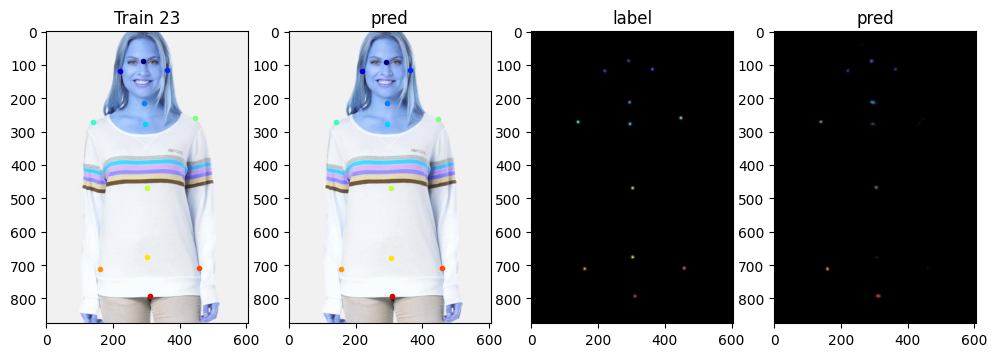

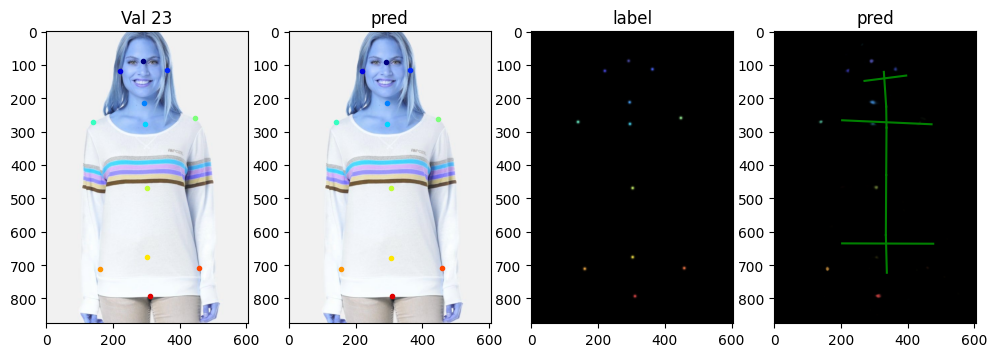

In [ ]:
# try the trained network out on training and val images
net.eval()
train_dataloader = torch.utils.data.DataLoader(train,
                                               batch_size=1,
                                               shuffle=True)
batch = next(iter(train_dataloader))

with torch.no_grad():
  train_hms1 = torch.sigmoid(net(batch['image'].to(device)))

fig=plt.figure(figsize=(12, 4*train_hms1.shape[0]), dpi= 100)
PlotLabelAndPrediction(batch,train_hms1,title_string='Train ')

with torch.no_grad():
  val_hms1 = net.output(batch['image'].to(device)) 
fig = plt.figure(figsize=(12, 4 * val_hms1.shape[0]), dpi=100)

PlotLabelAndPrediction(batch, val_hms1, title_string='Val ')



---
# Evaluation

In [ ]:
# Evaluate the training and validation error

def eval_net(net, loader):
  net.eval()
  n_val = len(loader) * loader.batch_size
  errs = None
  count = 0

  for batch in loader:

    with torch.no_grad():
      hm_preds = torch.sigmoid(net(batch['image'].to(device))).cpu().numpy()

    idx = np.argmax(hm_preds.reshape((hm_preds.shape[0],
                                      hm_preds.shape[1],
                                      hm_preds.shape[2] * hm_preds.shape[3])),
                    axis=2)
    loc_preds = np.zeros((hm_preds.shape[0], hm_preds.shape[1], 2))
    loc_preds[:, :, 1], loc_preds[:, :, 0] = np.unravel_index(idx,
                                                              hm_preds.shape[2:])

    loc_labels = batch['landmarks'].numpy()
    l2err = np.sqrt(np.sum((loc_preds - loc_labels)**2., axis=2))
    idscurr = batch['id'].numpy()

    if errs is None:
      errs = np.zeros((n_val, l2err.shape[1]))
      errs[:] = np.nan
      ids = np.zeros(n_val, dtype=int)

    errs[count:(count + l2err.shape[0]), :] = l2err
    ids[count:(count + l2err.shape[0])] = idscurr
    count += l2err.shape[0]
    
  errs = errs[:count, :]
  ids = ids[:count]

  net.train()

  return errs, ids


l2err_per_landmark_val, val_ids = eval_net(net, val_dataloader)
l2err_per_landmark_train, train_ids = eval_net(net, train_dataloader)

## Error distribution

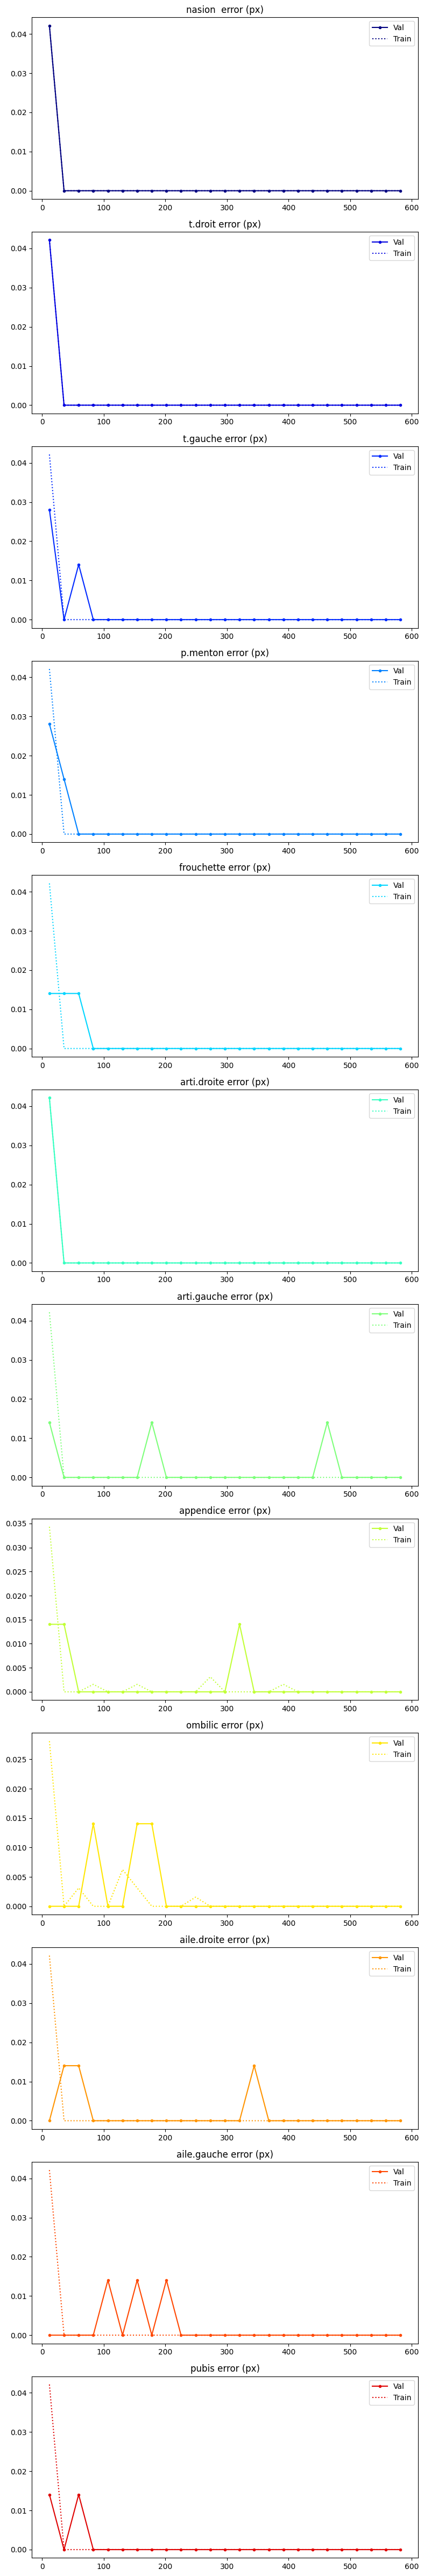

In [ ]:
# Plot the error distribution
nbins = 25
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
                        nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf
frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
for i in range(l2err_per_landmark_val.shape[1]):
  frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i],
                                   bin_edges, density=True)
  frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i],
                                     bin_edges, density=True)

fig = plt.figure(figsize=(8, 4 * train_dataset.nlandmarks), dpi=100)
for i in range(train_dataset.nlandmarks):
  if landmarks is None:
    landmark_name = landmark_names[i]
  else:
    landmark_name = landmark_names[landmarks[i]]
  plt.subplot(train_dataset.nlandmarks, 1, i + 1)
  hval = plt.plot(bin_centers,
                  frac_val[:, i], '.-',
                  label='Val', color=colors[i, :])
  plt.plot(bin_centers, frac_train[:, i], ':',
           label='Train', color=colors[i, :])
  plt.legend()
  plt.title(f"{landmark_name} error (px)")
plt.tight_layout()
plt.show()

IndexError: ignored

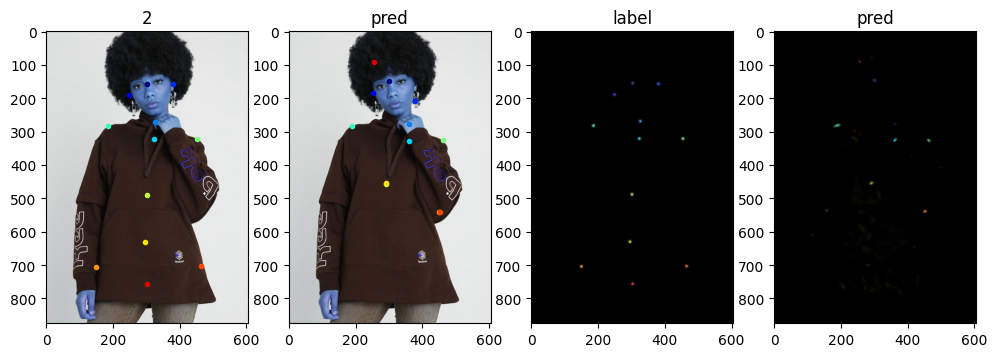

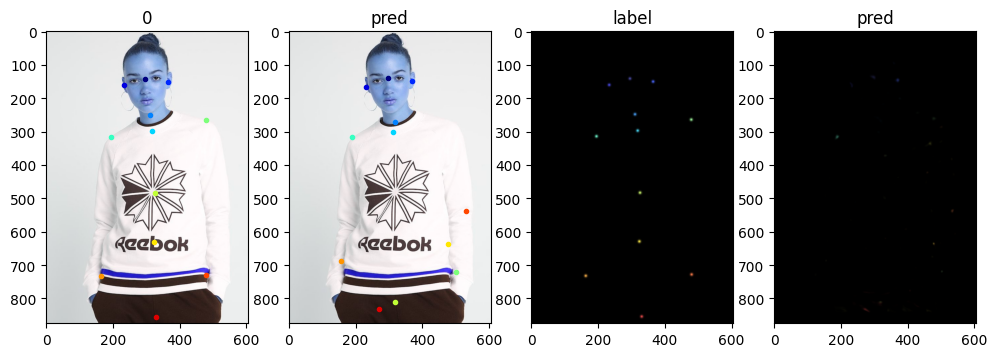

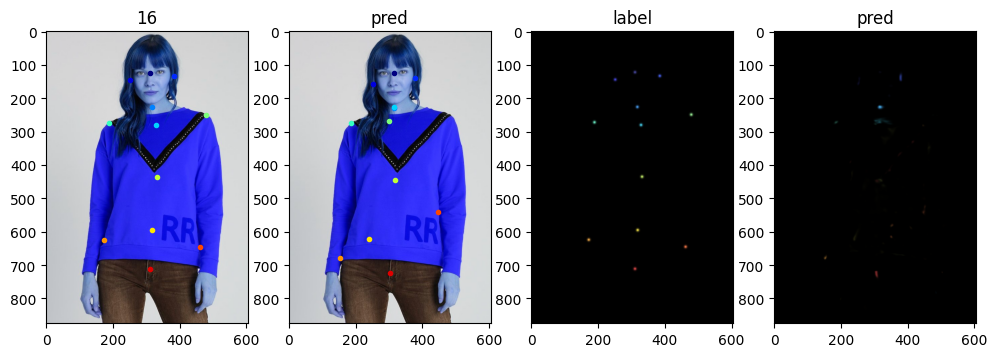

In [ ]:
# Plot examples with big errors
idx = np.argsort(-np.sum(l2err_per_landmark_val, axis=1))

for i in range(5):
  d = train_dataset[val_ids[idx[i]]]
  img = d['image'].unsqueeze(0)
  net.eval()
  with torch.no_grad():
    pred = net.output(img.to(device))

  fig=plt.figure(figsize=(12, 4), dpi=100)
  with np.printoptions(precision=2):
    errstr = str(l2err_per_landmark_val[idx[i]])
  PlotLabelAndPrediction(d,pred[0, ...])  #,title_string='Err = %s '%errstr)

## Visulaization of layers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


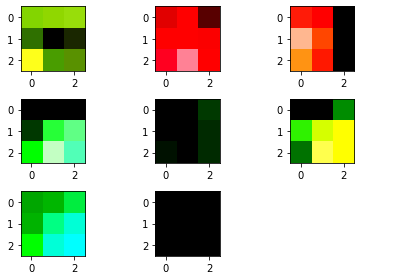

In [ ]:
# Visualize the first layer of convolutional features
with torch.no_grad():
  w = net.layer_inc.double_conv[0].weight.cpu().numpy()
nr = int(np.ceil(np.sqrt(w.shape[0])))
nc = int(np.ceil(w.shape[0] / nr))
fig, ax = plt.subplots(nr, nc)
for i in range(w.shape[0]):
  r, c = np.unravel_index(i, (nr, nc))
  fil = np.transpose(w[i, :, :, :], [1, 2, 0])
  if fil.shape[-1] == 1:
    fil = fil[:, :, 0]
  ax[r][c].imshow(fil)
  plt.axis('off')
plt.tight_layout()
plt.show()

## Final evaluation on the test set

In [ ]:
# final evaluation on the test set. for proper evaluation, and to avoid overfitting
# to the test set, we want to change parameters based on the validation set, and
# only at the very end evaluate on the test set

with open(testannfile) as f:
  testann = json.load(f)
f.close()
ntestims = len(testann['images'])
# Make sure we have all the images
t = glob(os.path.join(testdir, '*.jpg'))
print(f"N. test images = {ntestims}, number of images unzipped = {len(t)}")
assert ntestims==len(t), 'number of annotations and number of images do not match'

test_dataset = COCODataset(testannfile, datadir=testdir, landmarks=landmarks)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=2,
                                              shuffle=True)

l2err_per_landmark_test, test_ids = eval_net(net, test_dataloader)

N. test images = 30, number of images unzipped = 30


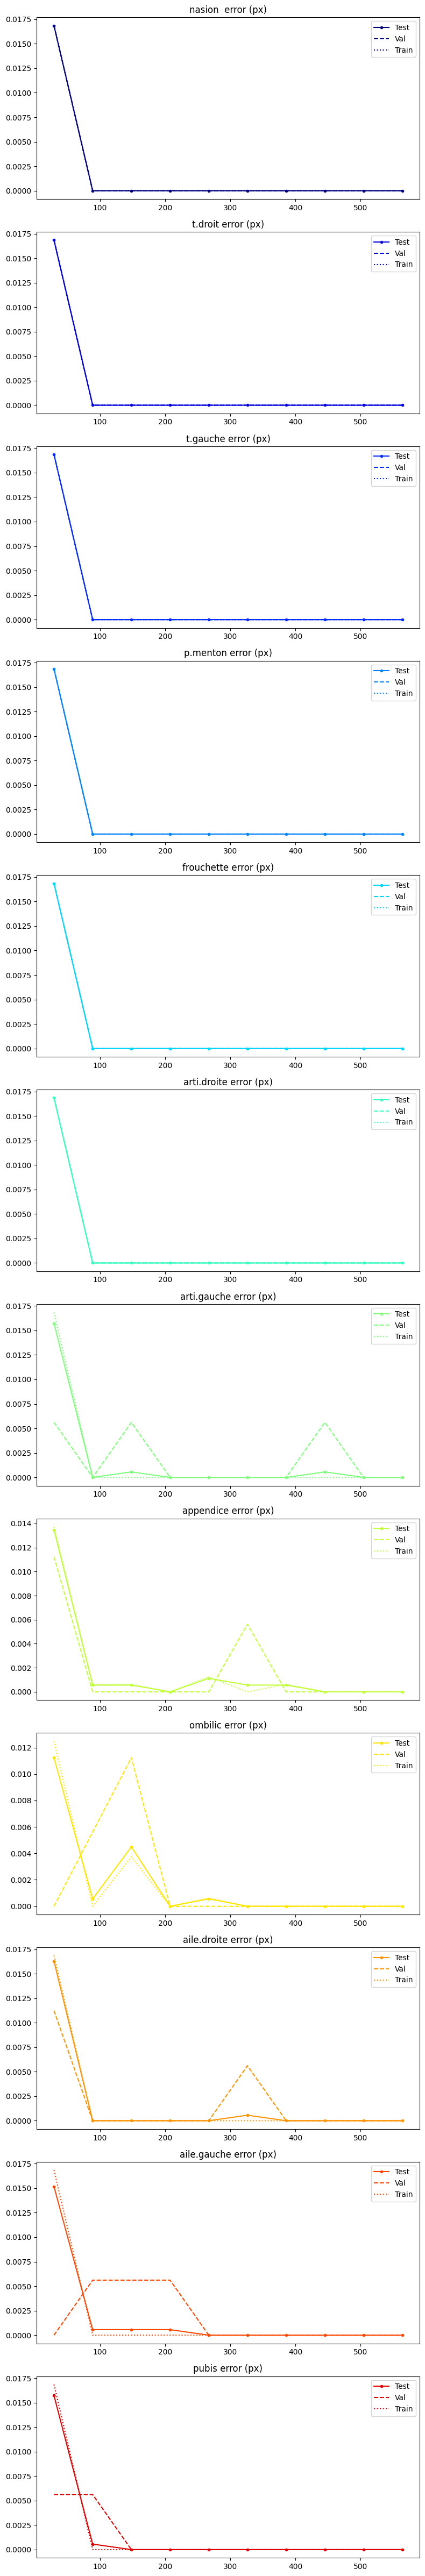

In [ ]:
# Plot the error distribution
nbins = 10
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
                        nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf
frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_test = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
for i in range(l2err_per_landmark_val.shape[1]):
  frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i],
                                   bin_edges, density=True)
  frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i],
                                     bin_edges, density=True)
  frac_test[:, i], _ = np.histogram(l2err_per_landmark_test[:, i],
                                    bin_edges, density=True)

fig=plt.figure(figsize=(8, 4 * train_dataset.nlandmarks), dpi=100)
for i in range(train_dataset.nlandmarks):
  if landmarks is None:
    landmark_name = landmark_names[i]
  else:
    landmark_name = landmark_names[landmarks[i]]
  plt.subplot(train_dataset.nlandmarks, 1, i + 1)
  plt.plot(bin_centers, frac_test[:, i], '.-',
           label='Test', color=colors[i, :])
  plt.plot(bin_centers, frac_val[:, i], '--',
           label='Val', color=colors[i, :])
  plt.plot(bin_centers, frac_train[:, i], ':',
           label='Train', color=colors[i, :])
  plt.legend()
  plt.title(f"{landmark_name} error (px)")
plt.tight_layout()
plt.show()

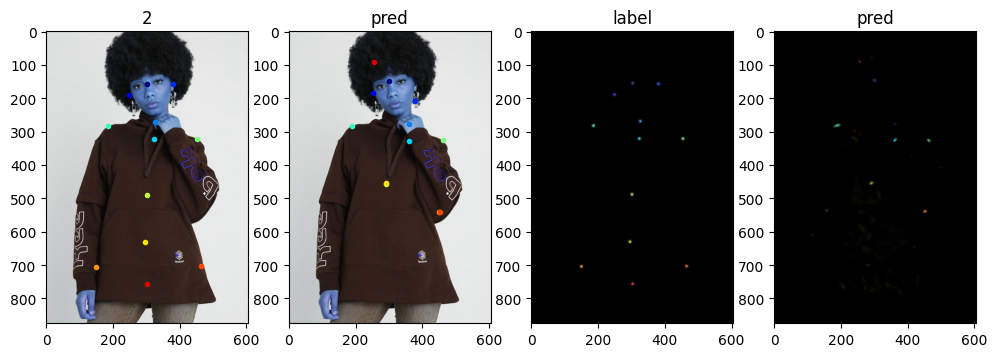

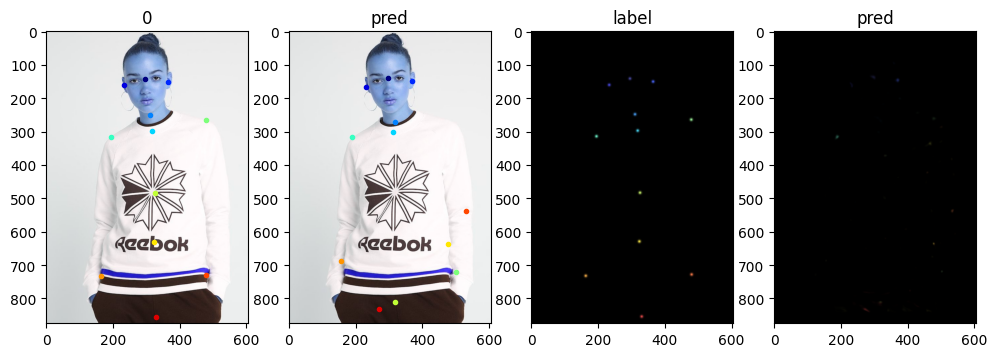

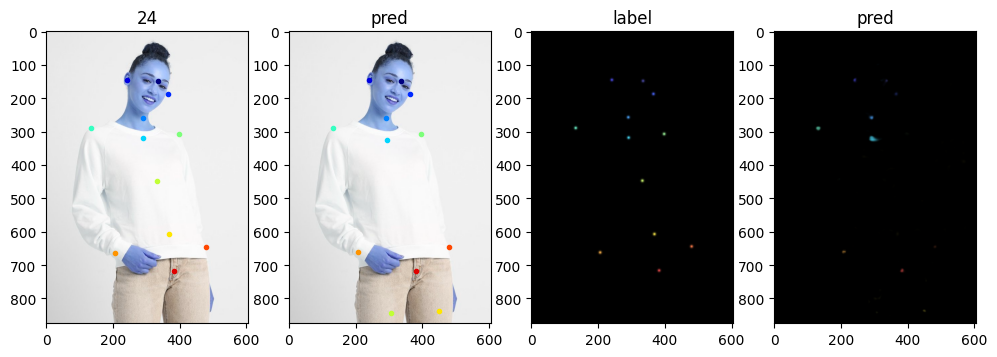

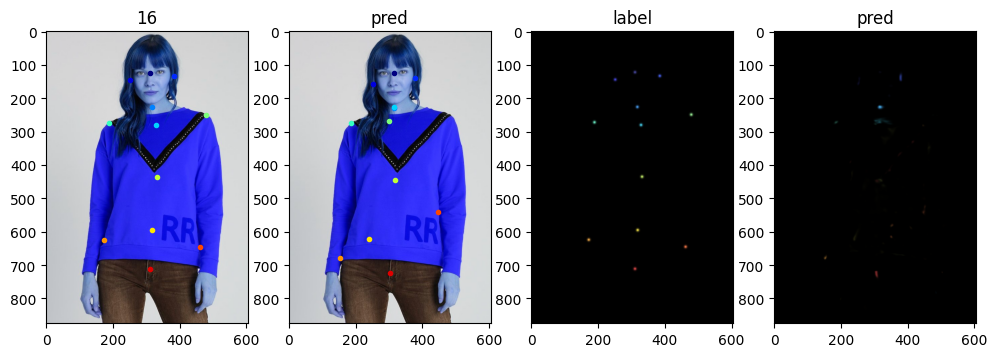

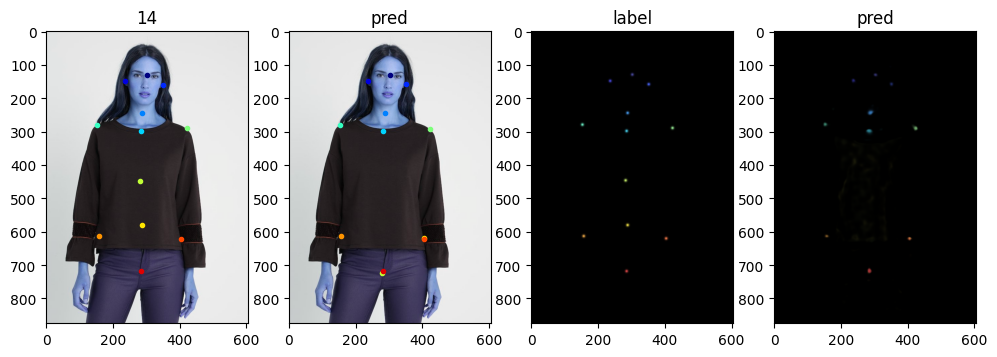

In [ ]:
# Plot examples with big errors
idx = np.argsort(-np.sum(l2err_per_landmark_test, axis=1))

for i in range(5):
  d = test_dataset[test_ids[idx[i]]]
  img = d['image'].unsqueeze(0)
  net.eval()
  with torch.no_grad():
    pred = net.output(img.to(device))

  fig=plt.figure(figsize=(12, 4), dpi=100)
  with np.printoptions(precision=2):
    errstr = str(l2err_per_landmark_test[idx[i]])
  PlotLabelAndPrediction(d, pred[0, ...])  #,title_string='Err = %s '%errstr)

In [ ]:
torch.save(net.state_dict(), 'net.pth')

# download checkpoint file
print(net)

inc: DoubleConv(
  (double_conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)
down1: Down(
  (maxpool_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): R